In [1]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [2]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3
Loading required package: phyloseq
Loading required package: ggplot2

microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2018 Leo Lahti et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:base’:

    transform

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.7
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo


In [3]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

This is loo version 2.0.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



In [4]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

Loading required package: DBI
Loading required package: preprocessCore
Loading required package: RMySQL
Loading required package: RPA
Loading required package: affy
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match,

In [5]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [6]:
head(meta_new)

subject_id sample_id time cc  age_d  age_d_s    bf_count bf_count_s  bf_ratio
1 207        sa_10000  post no   98.00  0.0320946 6.00      0.43948544 1       
2 388        sa_10038  post yes  98.00  0.0320946 0.00     -1.65710371 0       
3 381        sa_10118  post yes 108.00  0.5275689 6.59      0.64565004 1       
4 283        sa_10211  post yes 107.03  0.4795079 5.00      0.09005391 1       
5 216        sa_10230  post no  100.00  0.1311895 7.00      0.78891696 1       
6 277        sa_10247  pre  yes  79.00 -0.9093066 6.10      0.47442859 1

In [7]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [8]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance.

In [9]:
# how many NA? --> 4 CC and 1 no CC
# sd_to_df(pseq.rel) %>% filter(is.na(bf_count_s))
# complete cases for meta data and otus:
meta.rel <- sd_to_df(pseq.rel) %>% na.omit()
otus.rel <- otu_to_df(pseq.rel, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.rel$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.rel)
anova(betadisper(dist, meta.rel$cc))
anova(betadisper(dist, meta.rel$time))
anova(betadisper(dist, meta.rel$groups))
pm <- adonis(otus.rel ~ time * cc + age_d_s + bf_count_s, method = "bray", data = meta)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq     Mean Sq    F value   Pr(>F)   
Groups      1 0.01068249 0.01068249 0.2699714 0.6039755
Residuals 184 7.28068815 0.03956896        NA        NA

Df  Sum Sq     Mean Sq    F value Pr(>F)  
Groups      1 0.04615283 0.04615283 1.16548 0.281745
Residuals 184 7.28637289 0.03959985      NA       NA

Df  Sum Sq    Mean Sq    F value  Pr(>F)   
Groups      3 0.1296024 0.04320081 1.106879 0.3476826
Residuals 182 7.1033492 0.03902939       NA        NA

In [10]:
pm$aov.tab

Df  SumsOfSqs   MeanSqs    F.Model   R2          Pr(>F)
time         1  0.12804862 0.12804862 1.0703926 0.005701049 0.338 
cc           1  0.09689544 0.09689544 0.8099749 0.004314030 0.531 
age_d_s      1  0.26246060 0.26246060 2.1939784 0.011685411 0.049 
bf_count_s   1  0.30644654 0.30644654 2.5616686 0.013643776 0.038 
time:cc      1  0.13369958 0.13369958 1.1176306 0.005952644 0.315 
Residuals  180 21.53298690 0.11962771        NA 0.958703091    NA 
Total      185 22.46053768         NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


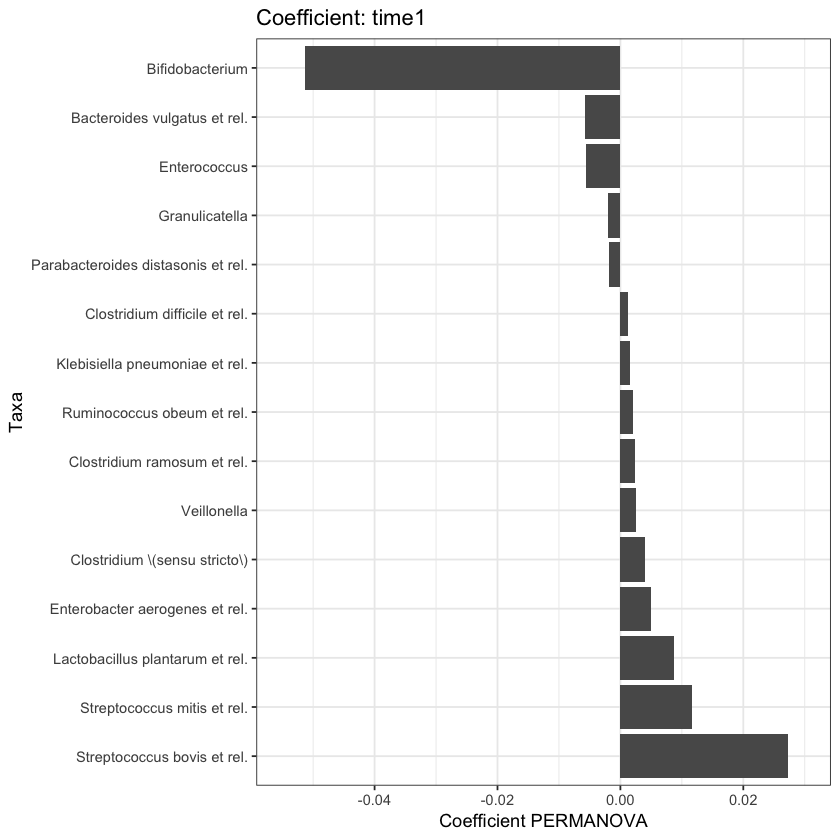

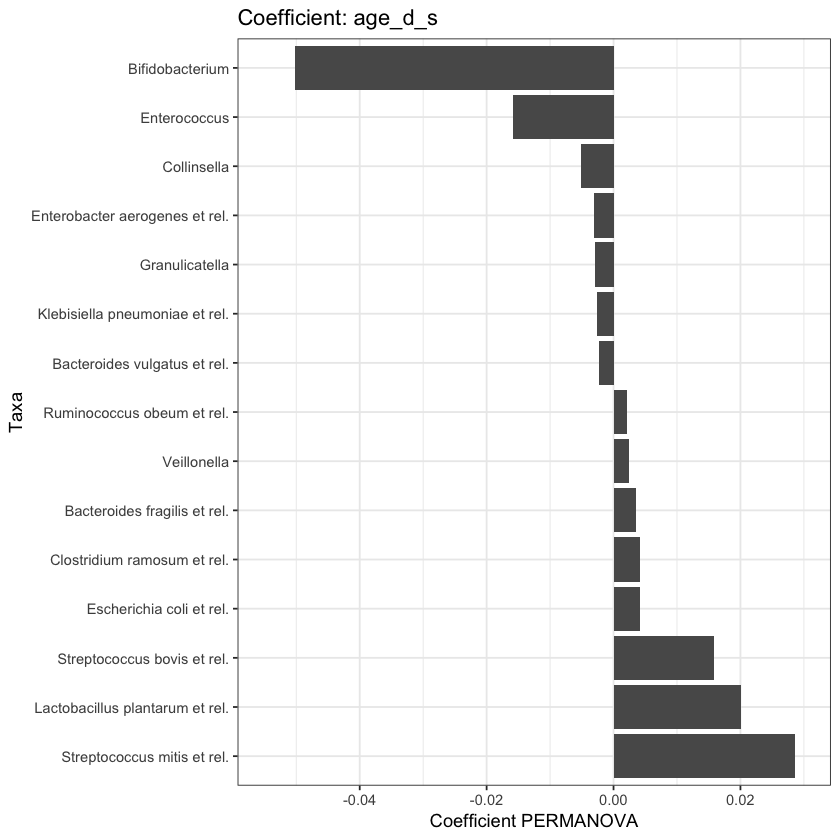

[[1]]

[[2]]

[[3]]

[[4]]


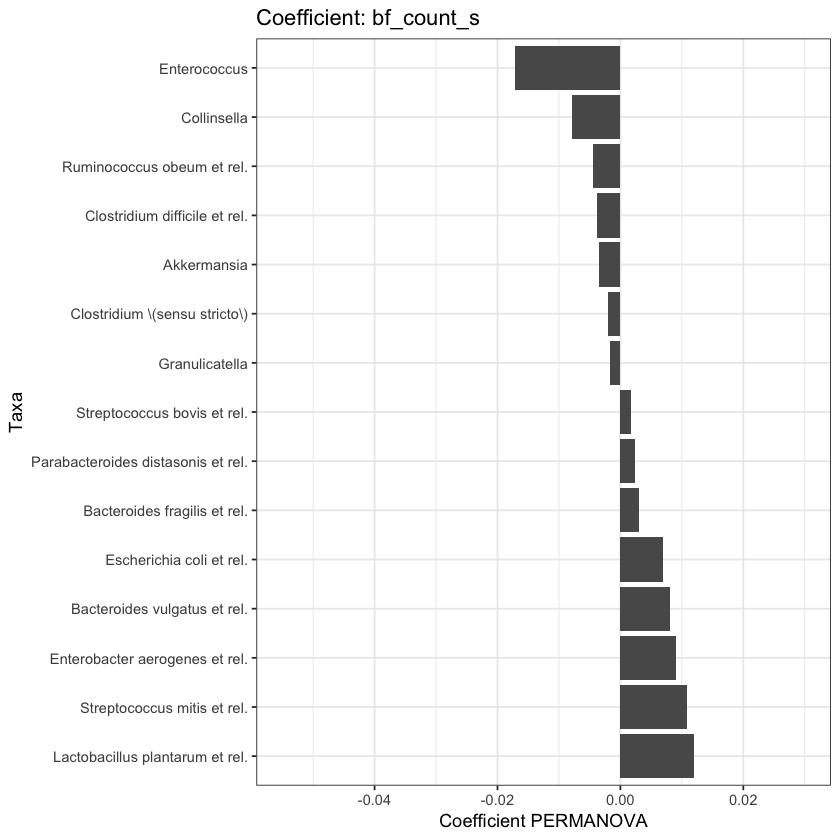

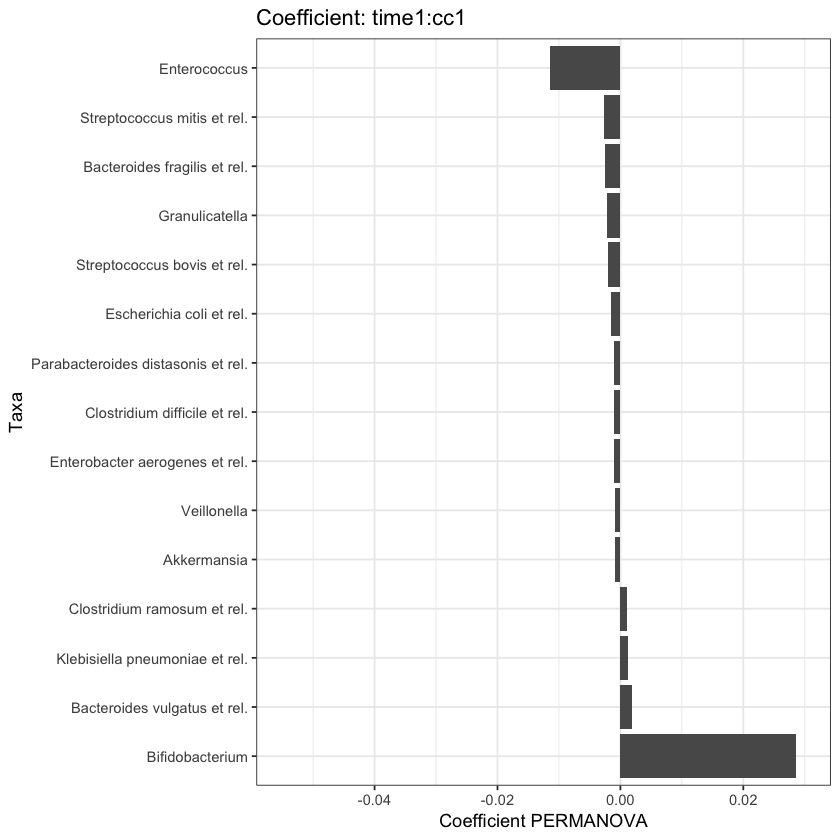

In [11]:
coef_v <- c("time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.055, 0.03) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_rel_ab.png")))
    p
})
pmps

In [12]:
# clr/euclidean
meta.clr <- sd_to_df(pseq.clr) %>% na.omit()
otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.clr$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.clr, method = "euclidean")
anova(betadisper(dist, meta.clr$cc))
anova(betadisper(dist, meta.clr$time))
anova(betadisper(dist, meta.clr$groups))
pm <- adonis(otus.clr ~ time * cc + age_d_s + bf_count_s, method = "euclidean", data = meta.clr)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq     Mean Sq   F value  Pr(>F)   
Groups      1   12.70196 12.701958 2.183617 0.1411959
Residuals 184 1070.31582  5.816934       NA        NA

Df  Sum Sq     Mean Sq   F value  Pr(>F)   
Groups      1   11.29962 11.299622 1.925838 0.1668927
Residuals 184 1079.59777  5.867379       NA        NA

Df  Sum Sq     Mean Sq  F value  Pr(>F)   
Groups      3   26.14299 8.714330 1.465733 0.2254241
Residuals 182 1082.05802 5.945374       NA        NA

In [13]:
pm$aov.tab

Df  SumsOfSqs  MeanSqs   F.Model   R2          Pr(>F)
time         1   54.24037  54.24037 1.3570877 0.007132593 0.164 
cc           1   46.46197  46.46197 1.1624731 0.006109736 0.271 
age_d_s      1   65.49923  65.49923 1.6387831 0.008613130 0.086 
bf_count_s   1  208.93921 208.93921 5.2276347 0.027475446 0.001 
time:cc      1   35.16046  35.16046 0.8797105 0.004623590 0.547 
Residuals  180 7194.27820  39.96821        NA 0.946045506    NA 
Total      185 7604.57944        NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
“Removed 1 rows containing missing values (position_stack).”Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
“Removed 1 rows containing missing values (position_stack).”

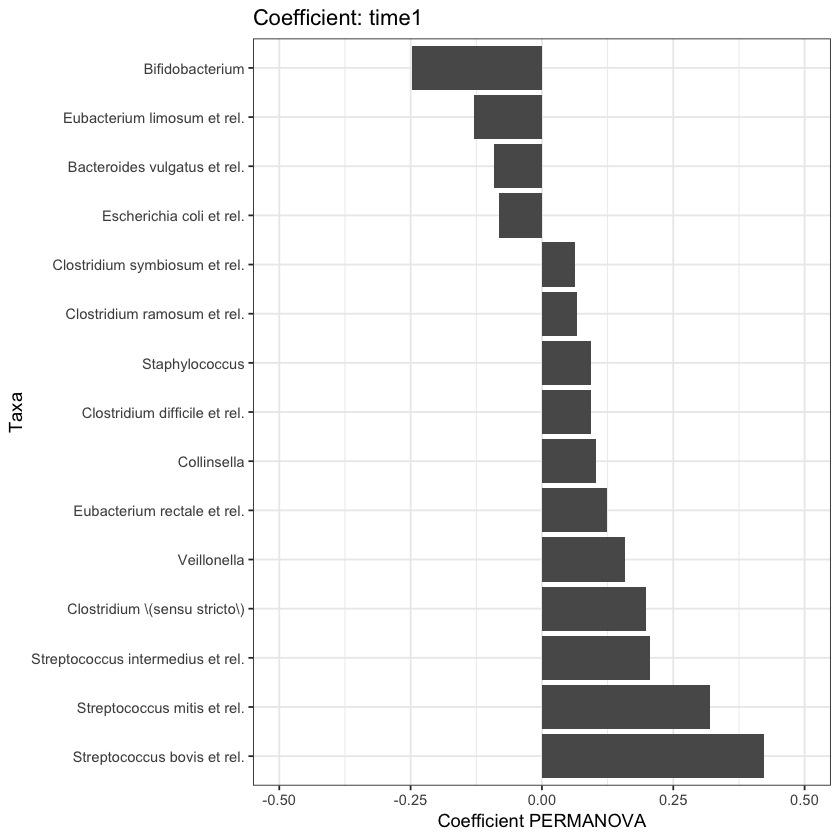

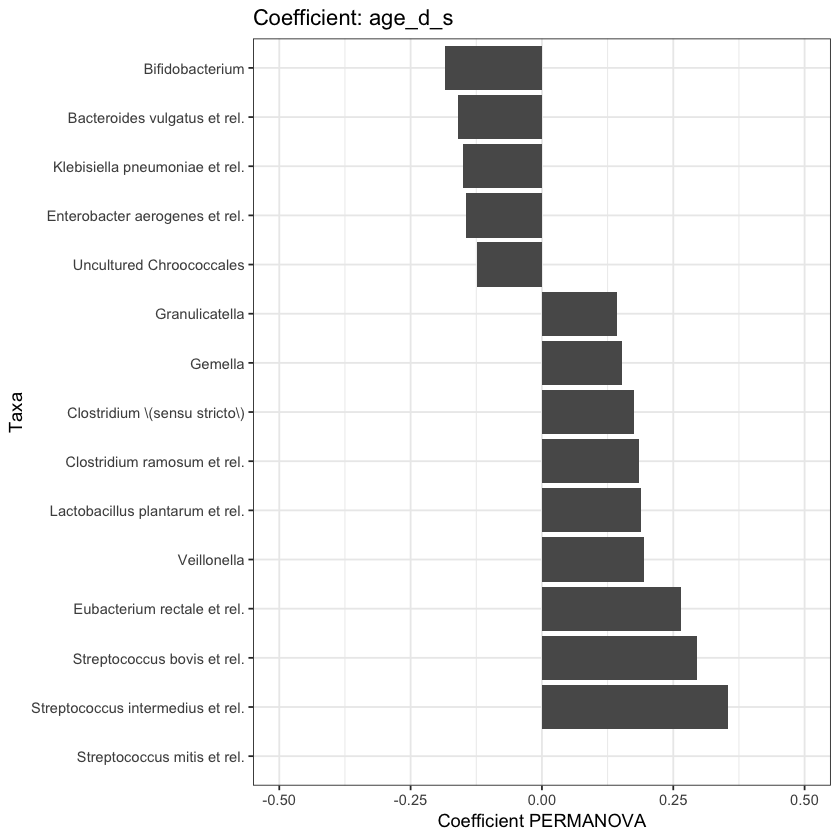

[[1]]

[[2]]

[[3]]

[[4]]


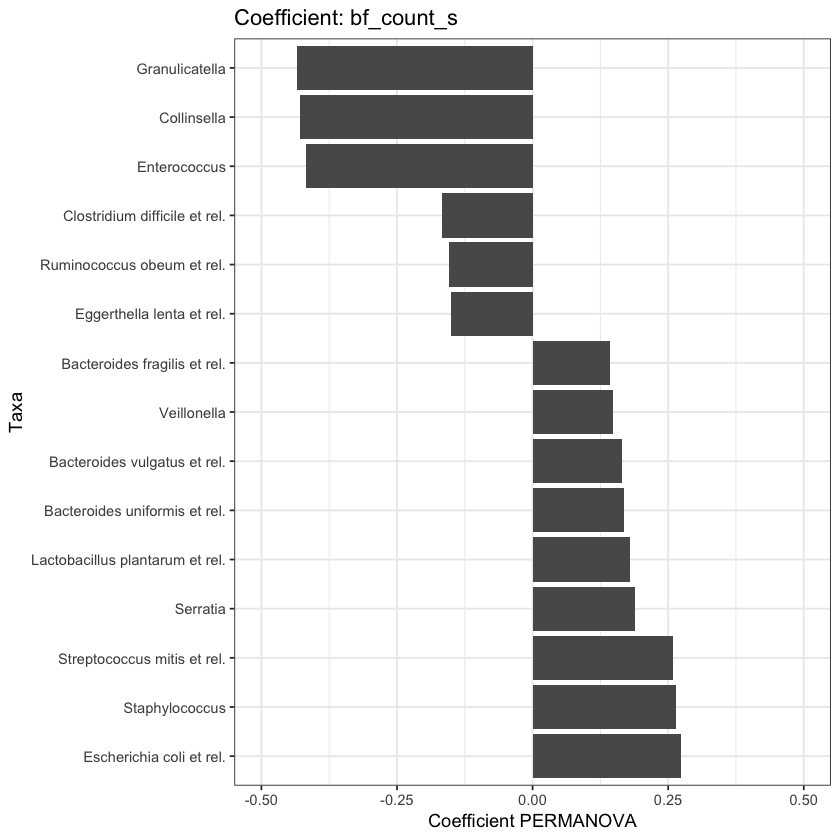

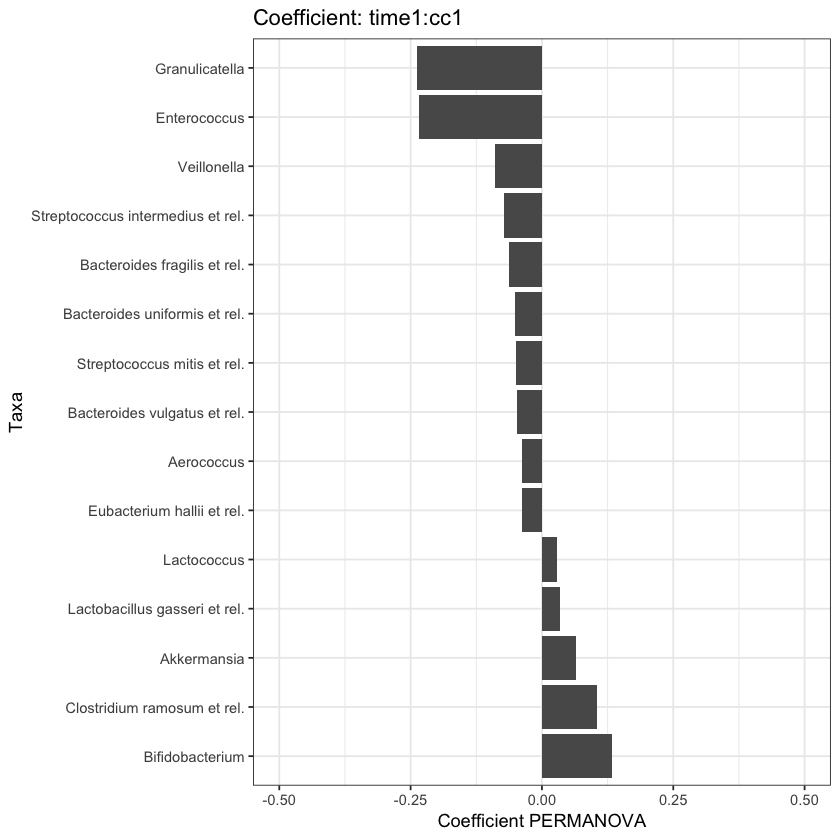

In [14]:
coef_v <- c("time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.5, 0.5) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_clr.png")))
    p
})
pmps

In [15]:
### make tables for permanovs apa
pm_table <- rownames_to_column(pm$aov.tab, "Model Parameters")
pm_table <- 
  mutate_if(pm_table, is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`)) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)
colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )

In [16]:
pm_table

Model Parameter Sum of Squares Mean Sum of Squares F     Df  p     R Square
1 time              54.240       54.24               1.357   1 0.164 0.007   
2 cc                46.462       46.462              1.162   1 0.271 0.006   
3 age_d_s           65.499       65.499              1.639   1 0.086 0.009   
4 bf_count_s       208.939       208.939             5.228   1 0.001 0.027   
5 time:cc           35.160       35.16               0.88    1 0.547 0.005   
6 Residuals       7194.278       39.968              -     180 -     0.946   
7 Total           7604.579       -                   -     185 -     1.000

# Principal Coordinate Analysis

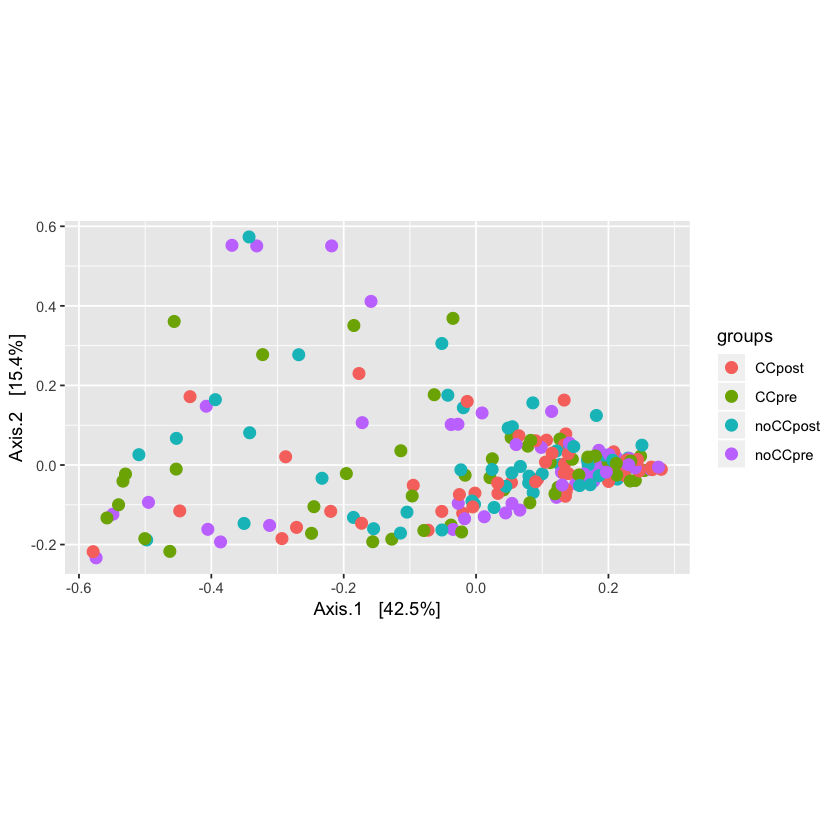

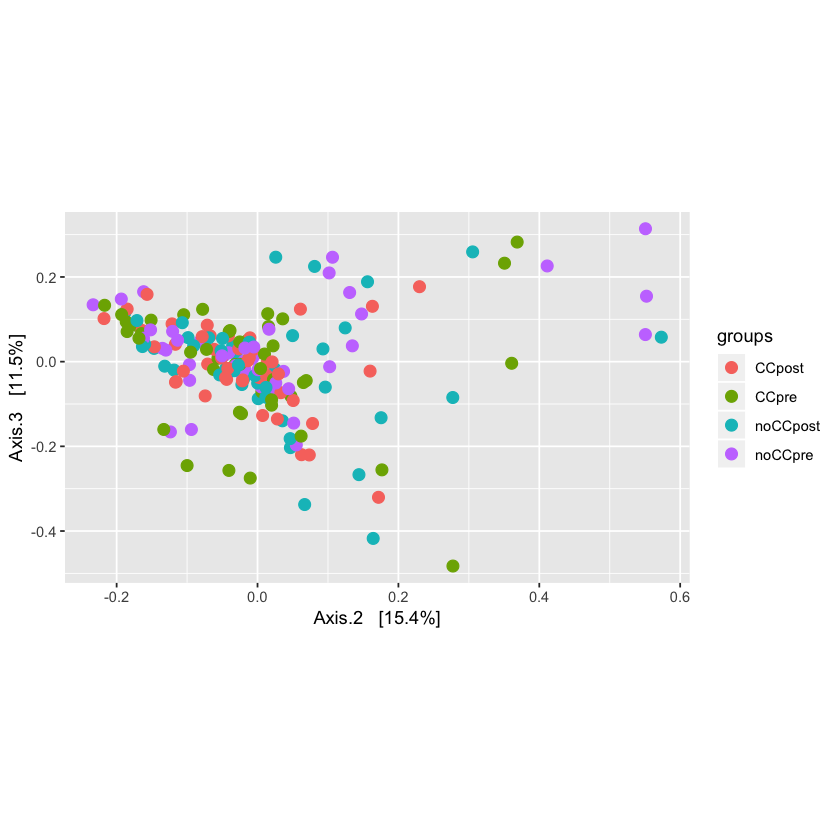

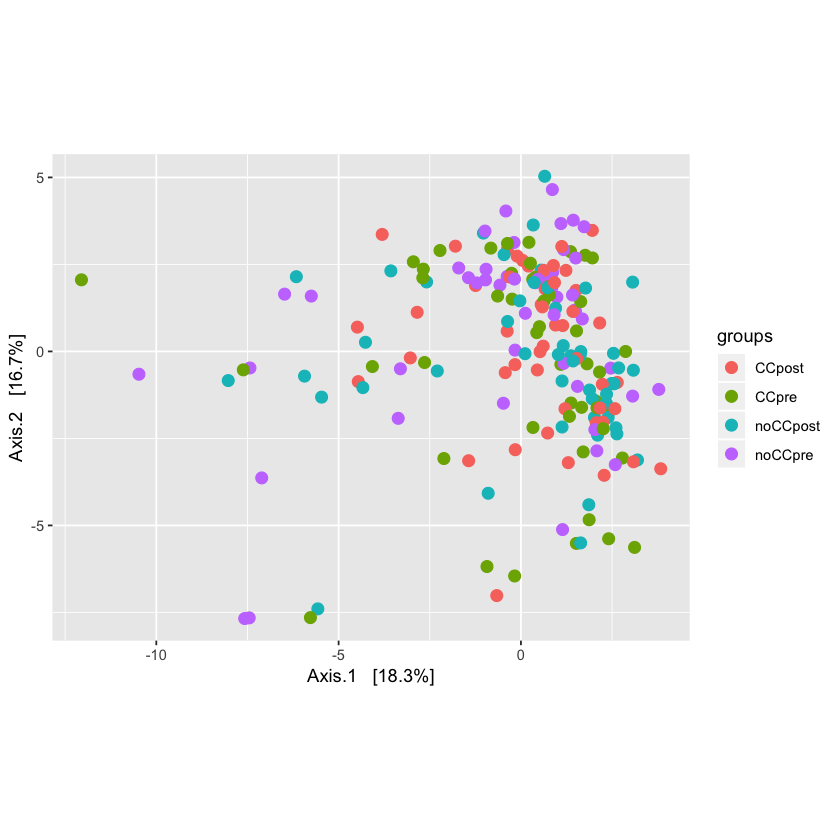

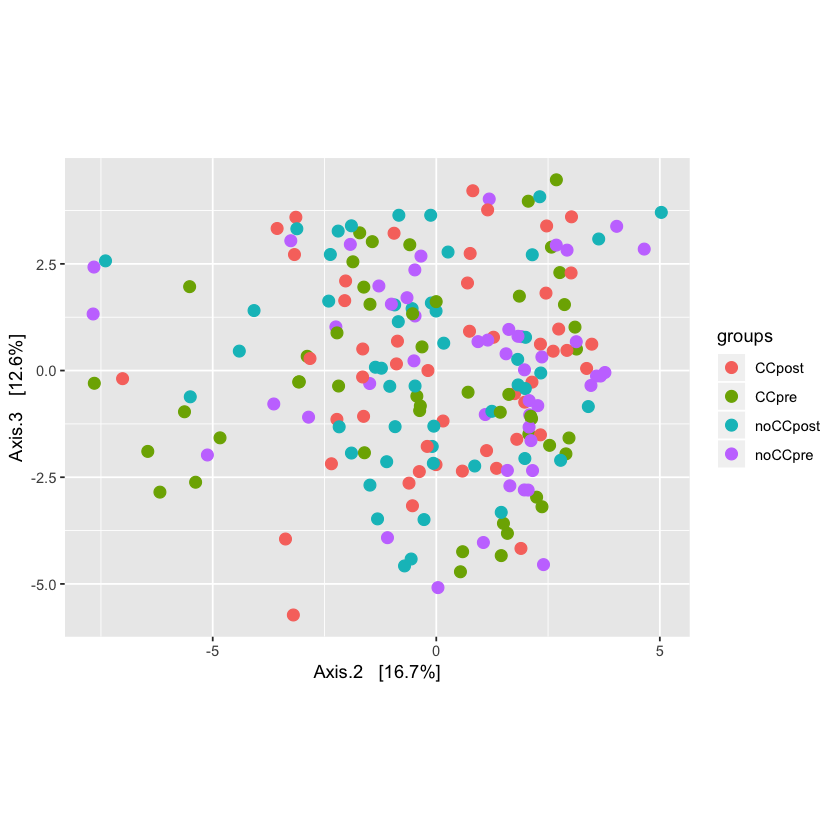

In [17]:
# PCoA bray, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.rel, method = "PCoA", distance = "bray")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.rel, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.rel, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 


# PCoA bray, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.clr, method = "PCoA", distance = "euclidean")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.clr, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.clr, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

# Hierarchical Generalized Linear Models

In [18]:
future::availableCores()

system 
     8

In [19]:
library(brms)
library(broom)
library(parallel)
options(mc.cores = 6)

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:affy’:

    mm

The following object is masked from ‘package:phyloseq’:

    nsamples



In [20]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

In [21]:
colnames(otus.clr)

[1] "sample_id"                         "Actinomycetaceae"                 
  [3] "Aerococcus"                        "Aeromonas"                        
  [5] "Akkermansia"                       "Alcaligenesfaecalisetrel"         
  [7] "Allistipesetrel"                   "Anaerobiospirillum"               
  [9] "Anaerofustis"                      "Anaerostipescaccaeetrel"          
 [11] "Anaerotruncuscolihominisetrel"     "Anaerovoraxodorimutansetrel"      
 [13] "Aneurinibacillus"                  "Aquabacterium"                    
 [15] "Asteroleplasmaetrel"               "Atopobium"                        
 [17] "Bacillus"                          "Bacteroidesfragilisetrel"         
 [19] "Bacteroidesintestinalisetrel"      "Bacteroidesovatusetrel"           
 [21] "Bacteroidesplebeiusetrel"          "Bacteroidessplachnicusetrel"      
 [23] "Bacteroidesstercorisetrel"         "Bacteroidesuniformisetrel"        
 [25] "Bacteroidesvulgatusetrel"          "Bifidobacterium"                  
 [27] "Bilophilaetrel"                    "Brachyspira"                      
 [29] "Bryantellaformatexigensetrel"      "Bulleidiamooreietrel"             
 [31] "Burkholderia"                      "Butyrivibriocrossotusetrel"       
 [33] "Campylobacter"                     "Catenibacteriummitsuokaietrel"    
 [35] "Clostridiumsensustricto"           "Clostridiumcellulosietrel"        
 [37] "Clostridiumcolinumetrel"           "Clostridiumdifficileetrel"        
 [39] "Clostridiumfelsineumetrel"         "Clostridiumleptumetrel"           
 [41] "Clostridiumnexileetrel"            "Clostridiumorbiscindensetrel"     
 [43] "Clostridiumramosumetrel"           "Clostridiumsphenoidesetrel"       
 [45] "Clostridiumstercorariumetrel"      "Clostridiumsymbiosumetrel"        
 [47] "Clostridiumthermocellumetrel"      "Collinsella"                      
 [49] "Coprobacilluscatenaformisetrel"    "Coprococcuseutactusetrel"         
 [51] "Corynebacterium"                   "Desulfovibrioetrel"               
 [53] "Dialister"                         "Doreaformicigeneransetrel"        
 [55] "Eggerthellalentaetrel"             "Enterobacteraerogenesetrel"       
 [57] "Enterococcus"                      "Escherichiacolietrel"             
 [59] "Eubacteriumbiformeetrel"           "Eubacteriumcylindroidesetrel"     
 [61] "Eubacteriumhalliietrel"            "Eubacteriumlimosumetrel"          
 [63] "Eubacteriumrectaleetrel"           "Eubacteriumsiraeumetrel"          
 [65] "Eubacteriumventriosumetrel"        "Faecalibacteriumprausnitziietrel" 
 [67] "Fusobacteria"                      "Gemella"                          
 [69] "Granulicatella"                    "Haemophilus"                      
 [71] "Helicobacter"                      "Klebisiellapneumoniaeetrel"       
 [73] "Lachnobacillusbovisetrel"          "Lachnospirapectinoschizaetrel"    
 [75] "Lactobacilluscatenaformisetrel"    "Lactobacillusgasserietrel"        
 [77] "Lactobacillusplantarumetrel"       "Lactobacillussalivariusetrel"     
 [79] "Lactococcus"                       "Leminorella"                      
 [81] "Megamonashypermegaleetrel"         "Megasphaeraelsdeniietrel"         
 [83] "Methylobacterium"                  "Micrococcaceae"                   
 [85] "Mitsuokellamultiacidaetrel"        "Moraxellaceae"                    
 [87] "Novosphingobium"                   "Oceanospirillum"                  
 [89] "Oscillospiraguillermondiietrel"    "OutgroupingclostridiumclusterXIVa"
 [91] "Oxalobacterformigenesetrel"        "Papillibactercinnamivoransetrel"  
 [93] "Parabacteroidesdistasonisetrel"    "Peptococcusnigeretrel"            
 [95] "Peptostreptococcusanaerobiusetrel" "Peptostreptococcusmicrosetrel"    
 [97] "Phascolarctobacteriumfaeciumetrel" "Prevotellamelaninogenicaetrel"    
 [99] "Prevotellaoralisetrel"             "Prevotellaruminicolaetrel"        
[101] "Prevotellatanneraeetrel"           "Propionibacterium"                
[103] "Proteusetrel"    

## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

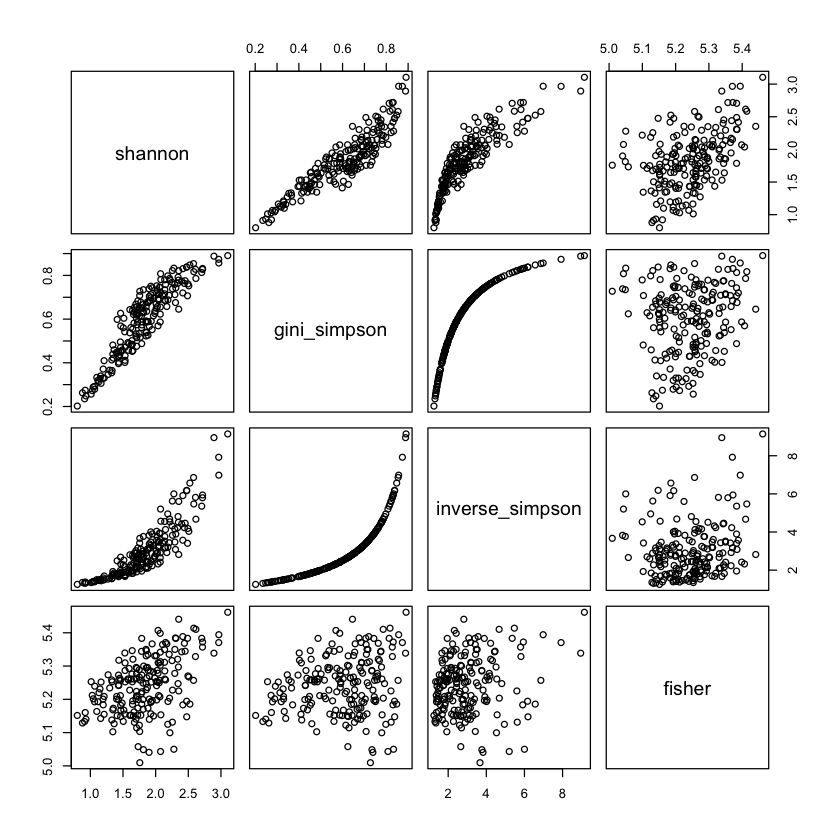

shannon   gini_simpson inverse_simpson fisher   
shannon         1.0000000 0.9164825    0.8751893       0.4663437
gini_simpson    0.9164825 1.0000000    0.8733145       0.1690172
inverse_simpson 0.8751893 0.8733145    1.0000000       0.1793258
fisher          0.4663437 0.1690172    0.1793258       1.0000000

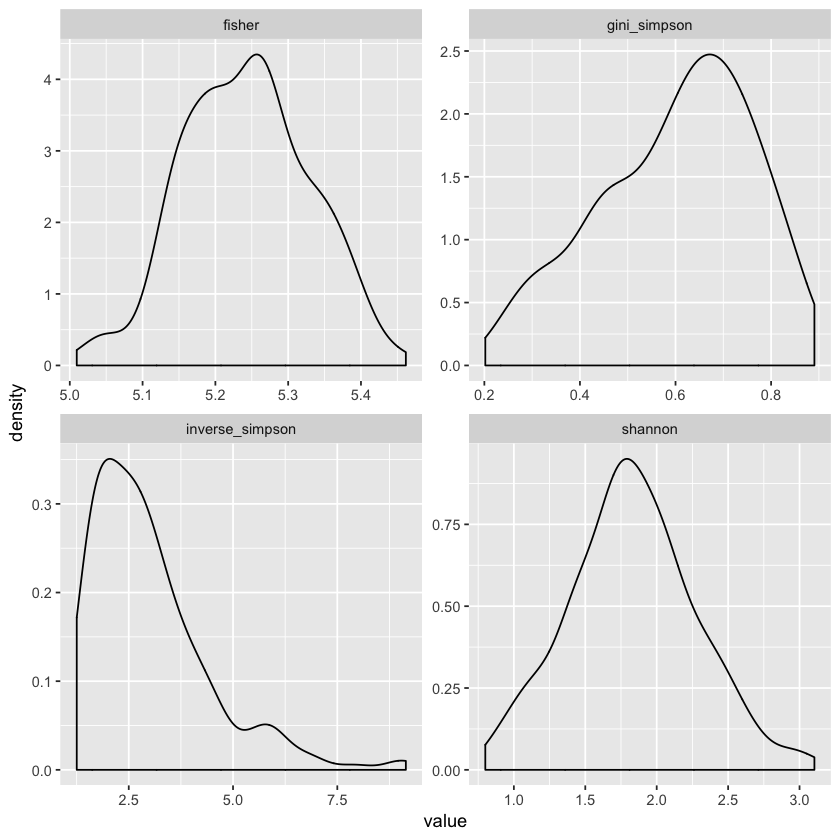

In [22]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [23]:
dir.create(here("models/final_analyses"))
folder <- here("models/final_analyses")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson", "fisher")

Warning message in dir.create(here("models/final_analyses")):
“'/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/final_analyses' already exists”

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [24]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [25]:
prior <- 
    c(
        set_prior("normal(0, 2)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )

brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [26]:
# gaussian family and listwise deletion
div_models <- lapply(diversity_index, brm_div)

In [27]:
# gaussian and mi for bf_count_s missingness
div_models_mi <- lapply(diversity_index, brm_div_mi)

In [28]:
# skew family and listwise deletion
div_models_skew <- lapply(diversity_index, brm_div_skew)

In [29]:
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- lapply(diversity_index, brm_div_skew_mi)

In [30]:
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [31]:
lapply(div_models_mi, function(x) {
    tidy(x)[1:13,]
})

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.89372706 0.08760532  1.753445984
2              b_bfcounts_Intercept  0.46234939 0.29386602 -0.015742227
3                   b_shannon_ccyes  0.02370585 0.09160557 -0.125224778
4                b_shannon_timepost -0.03032074 0.11223950 -0.211971957
5                 b_shannon_age_d_s  0.09488080 0.06176213 -0.006307064
6          b_shannon_ccyes:timepost -0.24639353 0.09381100 -0.400108162
7                  b_bfcounts_ccyes -0.03407822 0.19982350 -0.362423937
8               b_bfcounts_timepost -0.43910298 0.24045711 -0.831404010
9                b_bfcounts_shannon -0.13601546 0.12722321 -0.353022236
10               b_bfcounts_age_d_s -0.14331386 0.15061123 -0.392863281
11        b_bfcounts_ccyes:timepost  0.11835183 0.12698171 -0.093159905
12         bsp_shannon_mibf_count_s -0.07295101 0.03820602 -0.133894329
13 sd_subject_id__shannon_Intercept  0.26541893 0.04321883  0.192727029
          upper
1   2.037094811
2   0.943000411
3   0.171806143
4   0.153263707
5   0.196059967
6  -0.093027107
7   0.290132736
8  -0.042495427
9   0.067359881
10  0.097669637
11  0.326718760
12 -0.008321062
13  0.334479016

[[2]]
                                      term    estimate  std.error        lower
1               b_inversesimpson_Intercept  3.22569051 0.26070535  2.800951843
2                     b_bfcounts_Intercept  0.25419873 0.22339483 -0.106420185
3                   b_inversesimpson_ccyes  0.13468297 0.29144216 -0.342019559
4                b_inversesimpson_timepost -0.20417323 0.37400578 -0.816580885
5                 b_inversesimpson_age_d_s  0.32228711 0.17212246  0.041340731
6          b_inversesimpson_ccyes:timepost -0.75851277 0.38619160 -1.384214519
7                         b_bfcounts_ccyes -0.04469366 0.19992652 -0.381508917
8                      b_bfcounts_timepost -0.47929547 0.23013498 -0.863909877
9               b_bfcounts_inverse_simpson -0.01083126 0.03846016 -0.074336714
10                      b_bfcounts_age_d_s -0.12583155 0.14714968 -0.368492877
11               b_bfcounts_ccyes:timepost  0.15063834 0.12698477 -0.062067829
12         bsp_inversesimpson_mibf_count_s -0.13461956 0.11763954 -0.327359186
13 sd_subject_id__inversesimpson_Intercept  0.14195630 0.16876613  0.005596575
         upper
1   3.66170288
2   0.62681201
3   0.61395228
4   0.40479974
5   0.60788740
6  -0.10784776
7   0.28154172
8  -0.10893515
9   0.05152277
10  0.11563695
11  0.35262806
12  0.05923653
13  0.55019319

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.632562709 0.03363762  0.577647724
2                  b_bfcounts_Intercept  0.255714710 0.26844599 -0.189677044
3                   b_ginisimpson_ccyes  0.002755617 0.03628283 -0.056300891
4                b_ginisimpson_timepost -0.025604929 0.04377892 -0.096520875
5                 b_ginisimpson_age_d_s  0.044671334 0.02292286  0.006573206
6          b_ginisimpson_ccyes:timepost -0.086298474 0.03776556 -0.149878569
7                      b_bfcounts_ccyes -0.053484388 0.19976960 -0.384633111
8                   b_bfcounts_timepost -0.515652166 0.23456374 -0.891399649
9               b_bfcounts_gini_simpson -0.020617814 0.30809875 -0.529861910
10                   b_bfcounts_age_d_s -0.102261832 0.14850855 -0.352699703
11            b_bfcounts_ccyes:timepost  0.158869057 0.12880710 -0.050693480
12         bsp_ginisimpson_mibf_count_s -0.006784738 0.01416000 -0.030120438
13 sd_subject_id__ginisimpson_Intercept  0.094402430 0.01949762  0.062399541
         upper
1   0.68792285
2   0.70183659
3   0.06334454
4   0.04706110
5   0.08265053
6  -0.02423238
7   0.27393656
8  -0.12668582
9   0.47250104
10  0.14235810
11  0.37128422
12  0.01625591
13  0.12412522

[[4]]
                              term      estimate   std.error       lower
1               b_fisher_Intercept  5.2278223560 0.018066174  5.

In [32]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})
#lapply(div_models_skew_mi, plot)

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.88439961 0.08948574  1.733681580
2              b_bfcounts_Intercept  0.45135456 0.27270598  0.005144036
3                   b_shannon_ccyes  0.04833789 0.09769097 -0.112292605
4                b_shannon_timepost -0.03032499 0.11477478 -0.218164353
5                 b_shannon_age_d_s  0.09938759 0.06182313 -0.002107777
6          b_shannon_ccyes:timepost -0.26439782 0.09542340 -0.423324577
7                  b_bfcounts_ccyes -0.01936861 0.18564966 -0.323159946
8               b_bfcounts_timepost -0.37378396 0.21556695 -0.732124668
9                b_bfcounts_shannon -0.15262150 0.12165606 -0.357031937
10               b_bfcounts_age_d_s -0.15062888 0.13667574 -0.376072936
11        b_bfcounts_ccyes:timepost  0.09603023 0.12006110 -0.106110687
12         bsp_shannon_mibf_count_s -0.07389353 0.03860975 -0.135863883
13 sd_subject_id__shannon_Intercept  0.28417321 0.04850299  0.209750750
         upper
1   2.03161369
2   0.90418466
3   0.20676035
4   0.15692999
5   0.20223886
6  -0.10367155
7   0.28671921
8  -0.01618459
9   0.04574673
10  0.07560964
11  0.29680609
12 -0.01085610
13  0.35764147

[[2]]
                                      term     estimate  std.error       lower
1               b_inversesimpson_Intercept  3.226386996 0.17351370  2.94757889
2                     b_bfcounts_Intercept  0.202923677 0.21925428 -0.15924557
3                   b_inversesimpson_ccyes -0.114011137 0.17752844 -0.40417514
4                b_inversesimpson_timepost -0.068346923 0.21876420 -0.43471717
5                 b_inversesimpson_age_d_s  0.148743926 0.11209886 -0.02787599
6          b_inversesimpson_ccyes:timepost -0.261933840 0.23317444 -0.65113197
7                         b_bfcounts_ccyes -0.029725745 0.19246100 -0.34968131
8                      b_bfcounts_timepost -0.424796930 0.23122331 -0.80836883
9               b_bfcounts_inverse_simpson -0.005609759 0.03620502 -0.06608942
10                      b_bfcounts_age_d_s -0.120285592 0.14793128 -0.35714836
11               b_bfcounts_ccyes:timepost  0.122243060 0.12321355 -0.08417011
12         bsp_inversesimpson_mibf_count_s -0.054792519 0.06305977 -0.15641730
13 sd_subject_id__inversesimpson_Intercept  0.067325228 0.05888357  0.00455316
         upper
1   3.51501284
2   0.56225791
3   0.18298239
4   0.27486104
5   0.33867752
6   0.11412895
7   0.28461194
8  -0.04877715
9   0.05316490
10  0.12286306
11  0.32292940
12  0.04990787
13  0.18346060

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.626203128 0.03059580  0.575732125
2                  b_bfcounts_Intercept  0.201030153 0.26775310 -0.233855789
3                   b_ginisimpson_ccyes  0.015701699 0.03350009 -0.040026203
4                b_ginisimpson_timepost -0.026751817 0.03950818 -0.091274767
5                 b_ginisimpson_age_d_s  0.041533162 0.02064305  0.008825657
6          b_ginisimpson_ccyes:timepost -0.084734768 0.03465564 -0.142713890
7                      b_bfcounts_ccyes -0.039831353 0.19463838 -0.362587079
8                   b_bfcounts_timepost -0.434513718 0.22913305 -0.801177797
9               b_bfcounts_gini_simpson -0.005447869 0.29295612 -0.487518703
10                   b_bfcounts_age_d_s -0.113902207 0.14534421 -0.354815946
11            b_bfcounts_ccyes:timepost  0.127890349 0.12143100 -0.071717118
12         bsp_ginisimpson_mibf_count_s -0.004403476 0.01275915 -0.024702015
13 sd_subject_id__ginisimpson_Intercept  0.084716058 0.01995183  0.052409802
         upper
1   0.67607847
2   0.63824190
3   0.07021493
4   0.03834124
5   0.07732153
6  -0.02789801
7   0.28669738
8  -0.05944830
9   0.47934601
10  0.11934161
11  0.32444190
12  0.01665235
13  0.11572115

[[4]]
                              term     estimate   std.error       lower
1               b_fisher_Intercept  5.227132452 0.017768802  5.19777394
2      

In [33]:
tidy(div_models_skew[[1]]) %>% filter (term == "alpha")

term  estimate  std.error lower     upper   
1 alpha -1.971749 2.543389  -6.510013 1.694973

In [34]:
#posterior_samples(div_models_skew_mi) %>% colnames()

In [35]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost")) %>%
        rename(
            no_pre = glue("b_{var_name}_Intercept"), 
            yes_pre = glue("b_{var_name}_ccyes"),
            no_post = glue("b_{var_name}_timepost"),
            yes_post = glue("b_{var_name}_ccyes:timepost")) %>%
        mutate(
            yes_post = no_pre + yes_pre + no_post + yes_post,
            no_post = no_pre + no_post,
            yes_pre = no_pre + yes_pre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}


In [36]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df <- df %>% 
        mutate(            
            yespost_yespre = yes_post - yes_pre,
            yespost_nopre = yes_post - no_pre,
            yespost_nopost = yes_post - no_post) %>%
        select(yespost_yespre, yespost_nopre, yespost_nopost) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
})


[[1]]
# A tibble: 3 x 5
# Groups:   comparison [3]
  comparison     mean_diff  lower   upper  prob
  <chr>              <dbl>  <dbl>   <dbl> <dbl>
1 yespost_nopost    -0.223 -0.406 -0.0424 0.990
2 yespost_nopre     -0.253 -0.561  0.0400 0.950
3 yespost_yespre    -0.277 -0.499 -0.0444 0.990

[[2]]
# A tibble: 3 x 5
# Groups:   comparison [3]
  comparison     mean_diff lower   upper  prob
  <chr>              <dbl> <dbl>   <dbl> <dbl>
1 yespost_nopost    -0.624 -1.21 -0.0207 0.979
2 yespost_nopre     -0.828 -1.70  0.0706 0.966
3 yespost_yespre    -0.963 -1.71 -0.210  0.994

[[3]]
# A tibble: 3 x 5
# Groups:   comparison [3]
  comparison     mean_diff  lower   upper  prob
  <chr>              <dbl>  <dbl>   <dbl> <dbl>
1 yespost_nopost   -0.0835 -0.151 -0.0154 0.991
2 yespost_nopre    -0.109  -0.213  0.0163 0.970
3 yespost_yespre   -0.112  -0.197 -0.0304 0.995

[[4]]
# A tibble: 3 x 5
# Groups:   comparison [3]
  comparison     mean_diff   lower  upper  prob
  <chr>              <dbl>   <dbl>  <dbl> <dbl>
1 yespost_nopost  -0.00556 -0.0422 0.0303 0.617
2 yespost_nopre    0.0215  -0.0399 0.0835 0.251
3 yespost_yespre   0.00790 -0.0378 0.0514 0.371

Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image


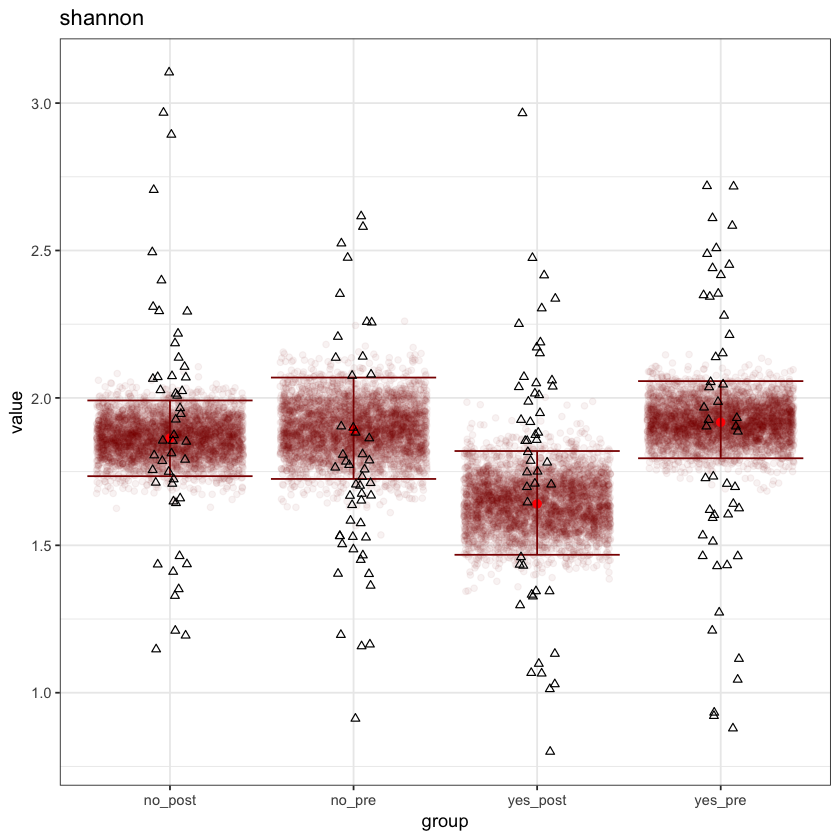

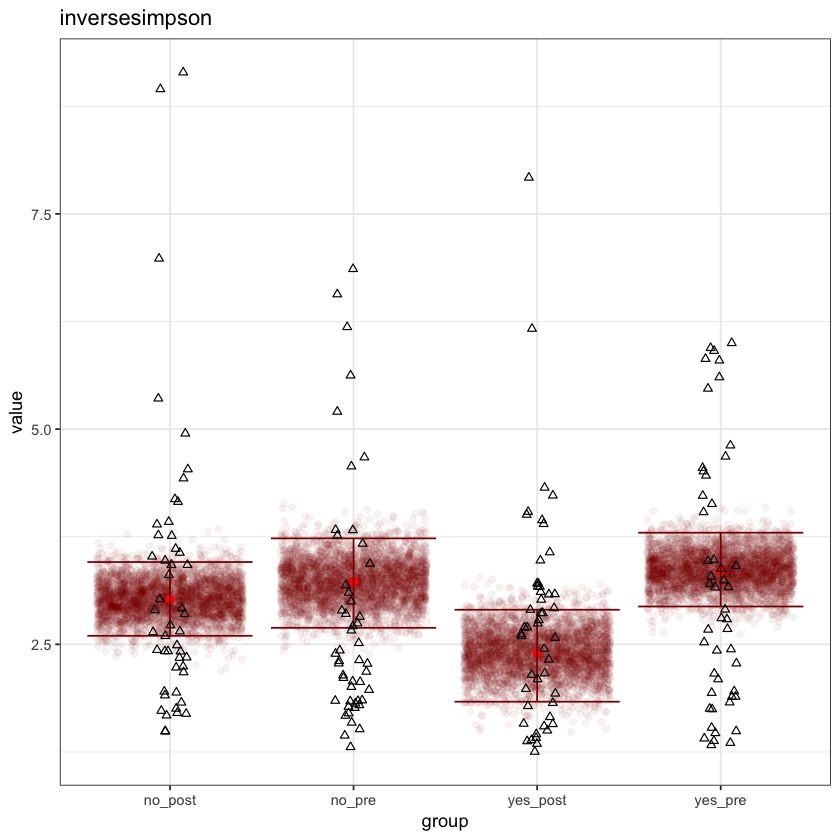

[[1]]

[[2]]

[[3]]

[[4]]


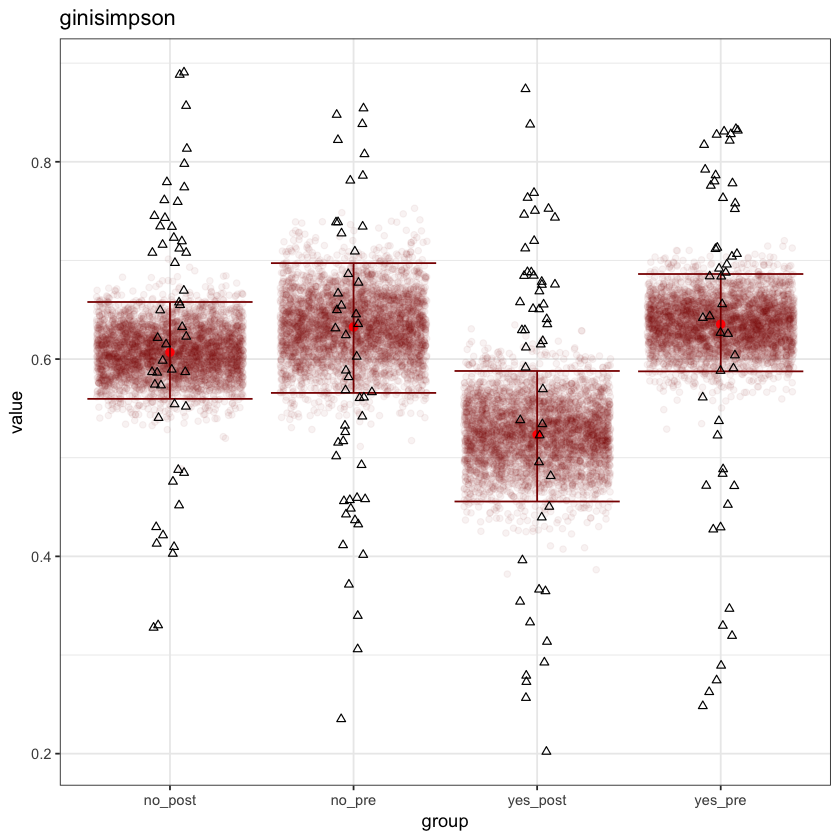

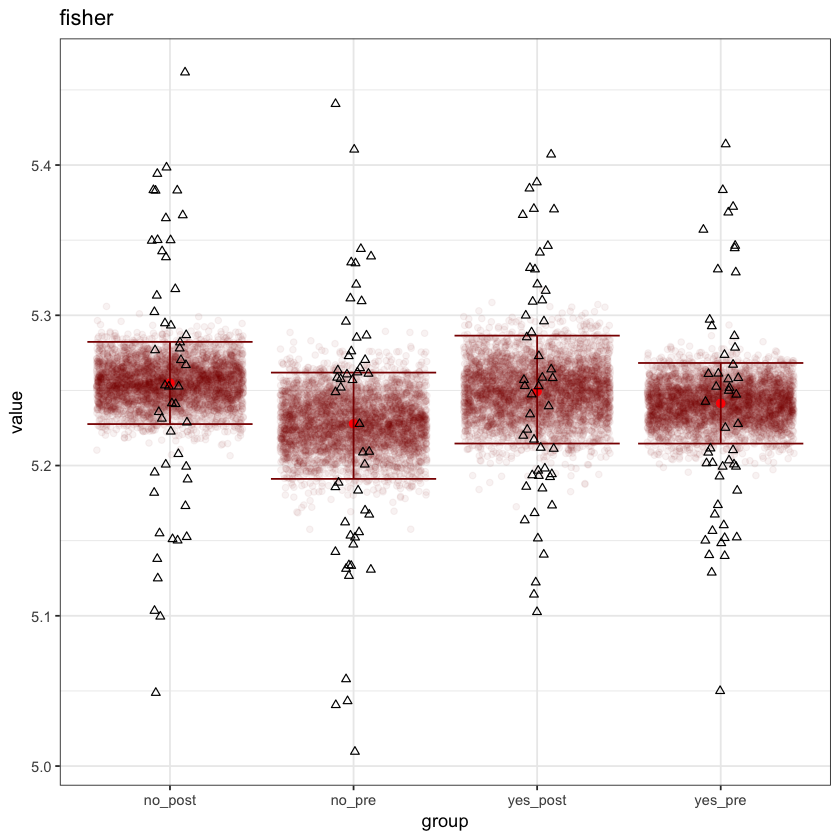

In [37]:
meta <- meta %>% mutate(
    group = ifelse(groups == "noCCpost", "no_post", ifelse(groups == "CCpost", "yes_post", ifelse(groups == "CCpre", "yes_pre", "no_pre")))
)
lapply(1:length(diversity_index), function(x) {
    p <- plot_effects(div_models_mi[[x]], diversity_index[x]) +
            geom_jitter(data = meta, aes_string("group", diversity_index[x]), width = 0.1, shape = 2)
    ggsave(here(glue("fig/parameter_plot_{x}.png")))
    p
    })


# Differential abundance testing

In [38]:
# specify prior 
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/final_analyses/differential_abundance/")

# define fitting function for fixed sigma
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [39]:
# can only always check a subset of models due to low memory
models_sn <- lapply(genus[1:50], brm_sn_mi)

In [40]:
# model screening/excluding skew_normal
exclude_id <- c()
for (i in 1:130) {
    fit <- brm_sn_mi(genus[i])
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]             
    # check if there are divergent transitions
    if (n_high_rhat > 0) {
        print(glue("{genus[i]} has {n_high_rhat} high Rhat parameter values"))
        exclude_id <- c(exclude_id, i)
    } else if (n_divergent$n > 0){
        print(glue("{genus[i]} has {n_divergent$n} divergent transitions"))
        exclude_id <- c(exclude_id, i)
    }     
}
genus_sel <- genus[-exclude_id]



Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Actinomycetaceae has 2 high Rhat parameter values


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Bacteroidesfragilisetrel has 1 divergent transitions


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Bryantellaformatexigensetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Butyrivibriocrossotusetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Catenibacteriummitsuokaietrel has 3 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Clostridiumsensustricto has 2 high Rhat parameter values


Warning message:
“There were 10 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Clostridiumdifficileetrel has 10 divergent transitions


Warning message:
“There were 139 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Clostridiumnexileetrel has 139 divergent transitions


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Clostridiumsphenoidesetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 448 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Lactobacillussalivariusetrel has 7 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

OutgroupingclostridiumclusterXIVa has 4 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 112 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Peptococcusnigeretrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Prevotellamelaninogenicaetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Prevotellaruminicolaetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 15 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Ruminococcuslactarisetrel has 1 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Subdoligranulumvariableatrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 10 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

UnculturedChroococcales has 4 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

UnculturedClostridialesI has 3 high Rhat parameter values


Warning message:
“There were 12 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Vibrio has 12 divergent transitions


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 186 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Wissellaetrel has 3 high Rhat parameter values


In [41]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost"), 
            glue("b_{var_name}_age_d_s"), 
            glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        rename(
            no_pre = glue("b_{var_name}_Intercept"), 
            yes_pre = glue("b_{var_name}_ccyes"),
            no_post = glue("b_{var_name}_timepost"),
            yes_post = glue("b_{var_name}_ccyes:timepost"),
            age = glue("b_{var_name}_age_d_s"),
            bf = glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        mutate(
            yes_post = no_pre + yes_pre + no_post + yes_post,
            no_post = no_pre + no_post,
            yes_pre = no_pre + yes_pre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}



In [42]:
effect_age <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
effect_bf <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
effect_yespre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
effect_nopre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
effect_nopost <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
for (var_name in genus_sel) {
    fit <- brm_sn_mi(var_name)
    df <- calc_treatment_effect(fit, var_name, summarise = F)
    df <- df %>% 
        mutate(            
            yespost_yespre = yes_post - yes_pre,
            yespost_nopre = yes_post - no_pre,
            yespost_nopost = yes_post - no_post) %>%
        select(yespost_yespre, yespost_nopre, yespost_nopost, age, bf) %>%
        gather(effect, value) %>%
        group_by(effect) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    effect_age <- rbind(effect_age, tibble(genus = var_name, mean = df$mean[1], lower = df$lower[1], upper = df$upper[1], prob = df$prob[1], effect = "age"))
    effect_bf <- rbind(effect_bf, tibble(genus = var_name, mean = df$mean[2], lower = df$lower[2], upper = df$upper[2], prob = df$prob[2], effect = "bf"))
    effect_yespre <- rbind(effect_yespre, tibble(genus = var_name, mean = df$mean[3], lower = df$lower[3], upper = df$upper[3], prob = df$prob[3], effect = "yespre"))
    effect_nopre <- rbind(effect_nopre, tibble(genus = var_name, mean = df$mean[4], lower = df$lower[4], upper = df$upper[4], prob = df$prob[4], effect = "nopre"))
    effect_nopost <- rbind(effect_nopost, tibble(genus = var_name, mean = df$mean[5], lower = df$lower[5], upper = df$upper[5], prob = df$prob[5], effect = "nopost"))                 
}

effect_age <- na.omit(effect_age)
effect_bf <- na.omit(effect_bf)
effect_yespre <- na.omit(effect_yespre)
effect_nopre <- na.omit(effect_nopre)
effect_nopost <- na.omit(effect_nopost)

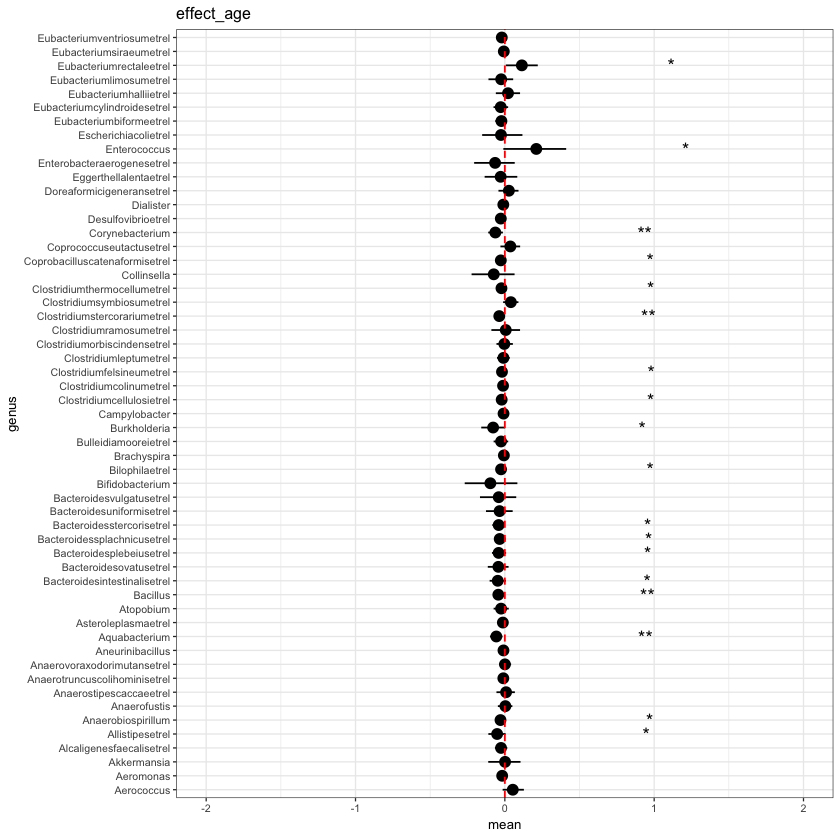

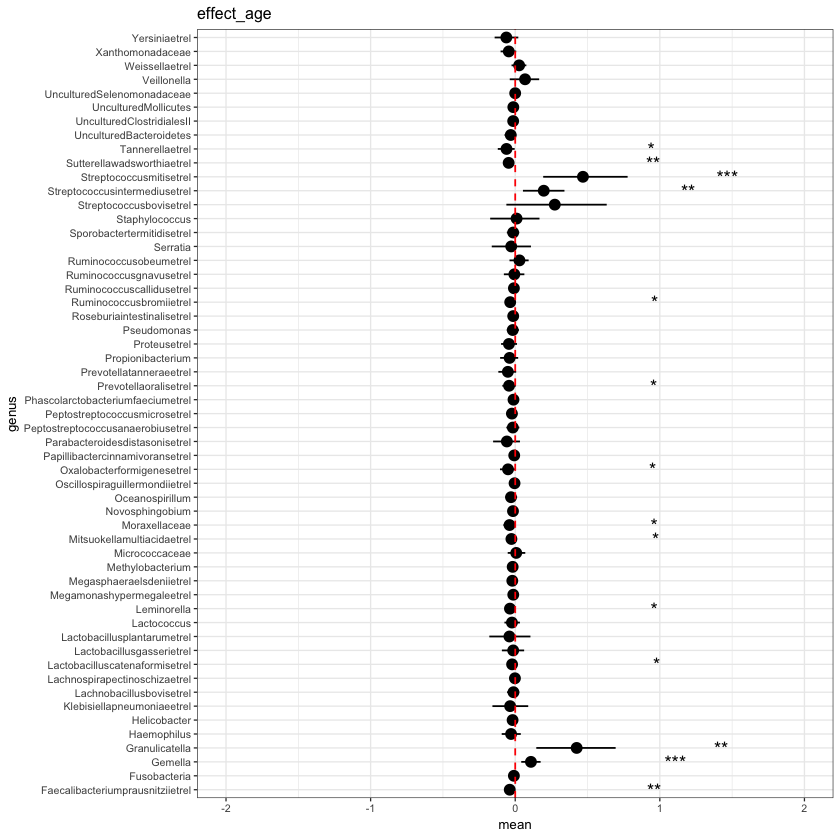

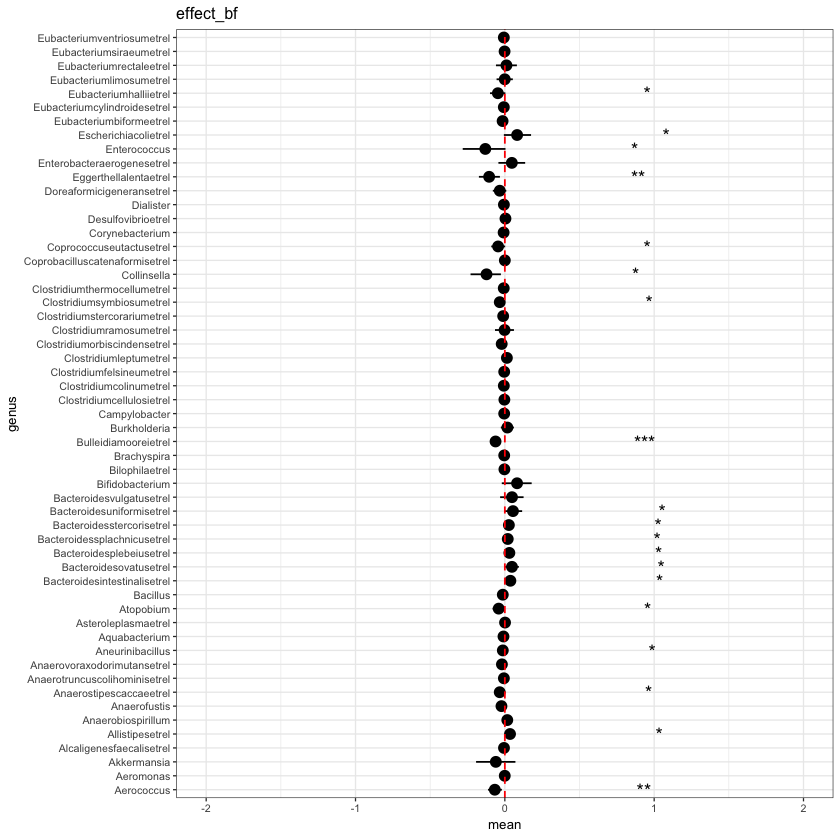

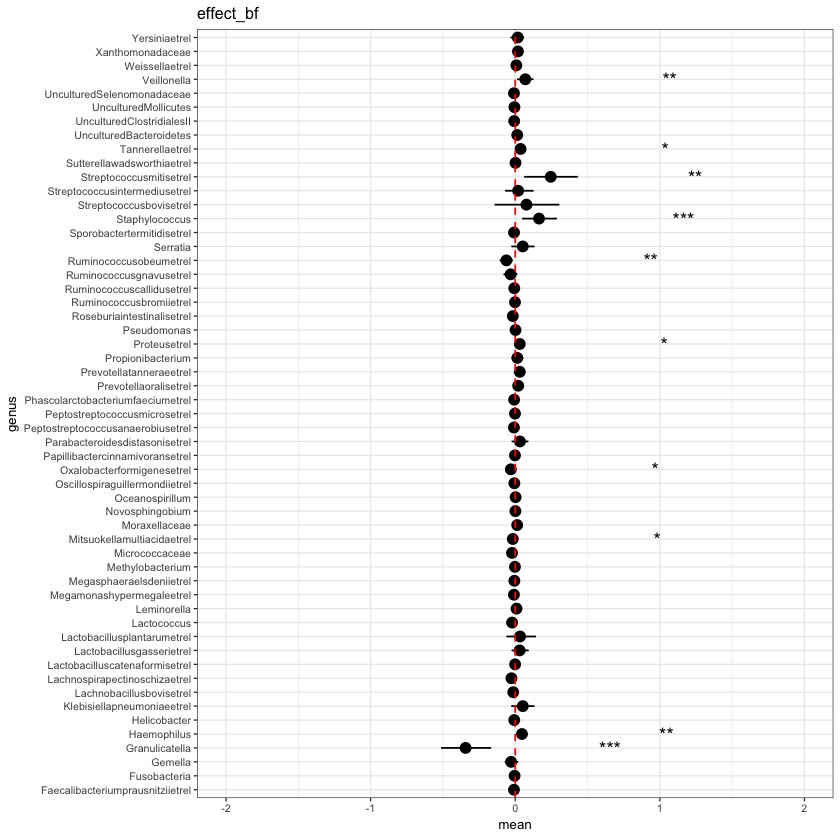

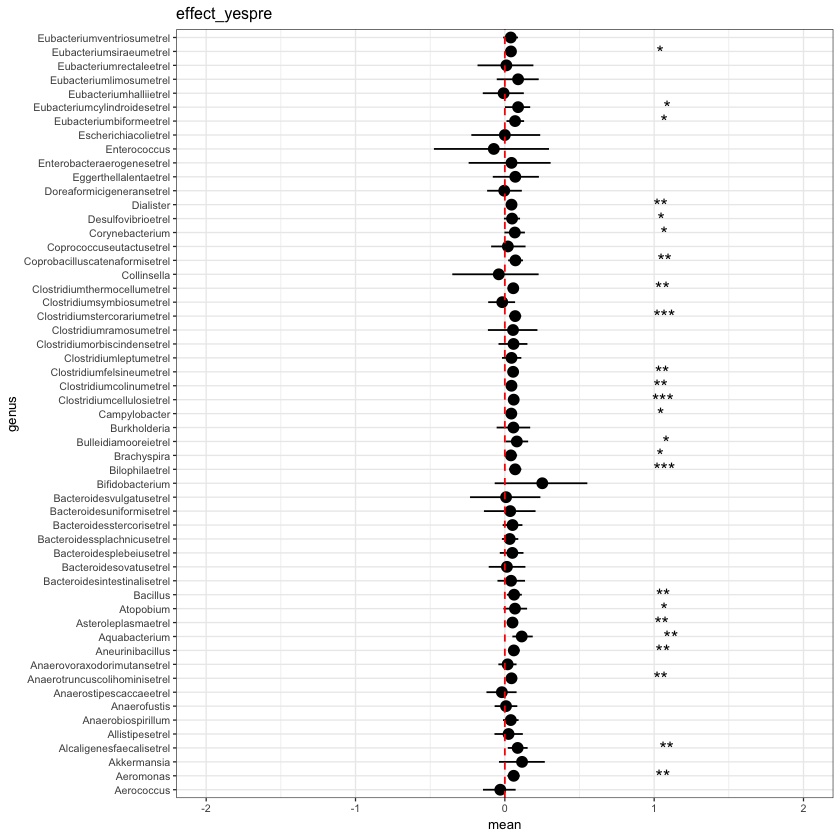

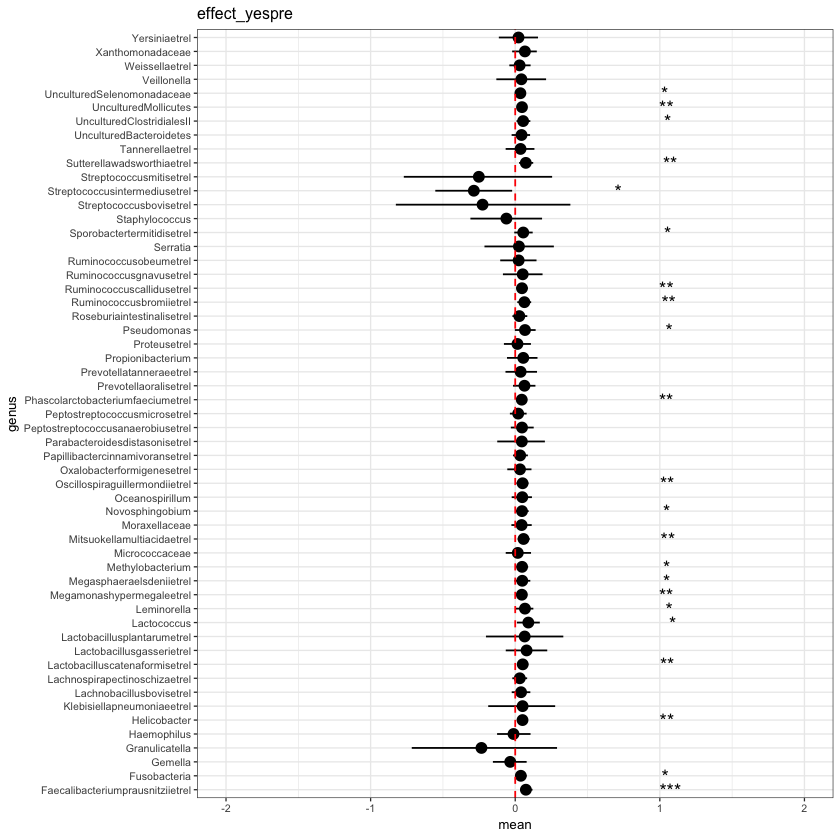

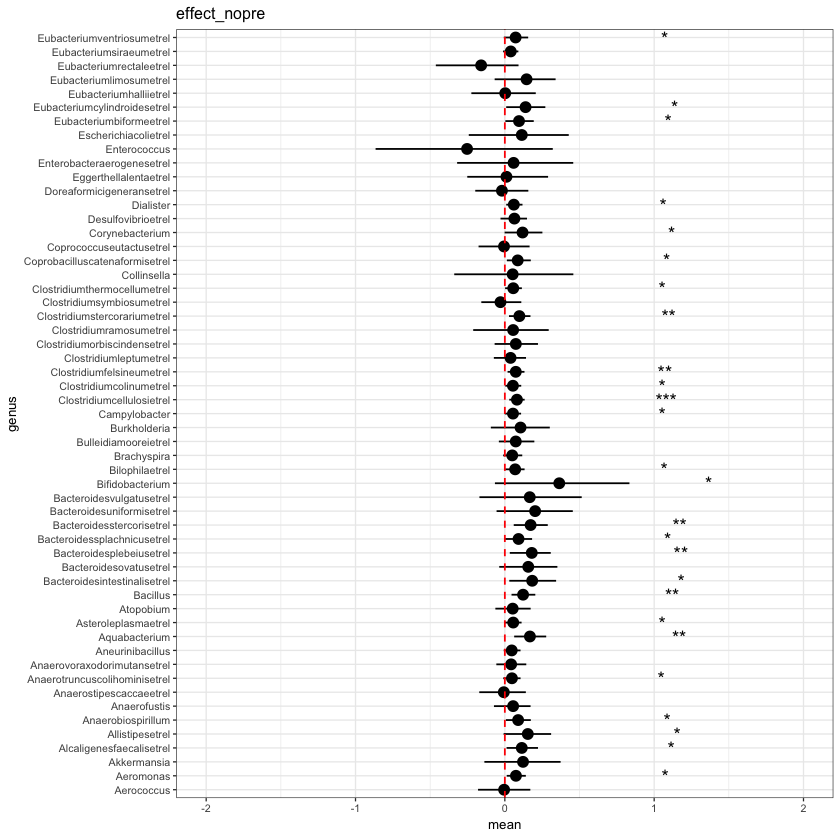

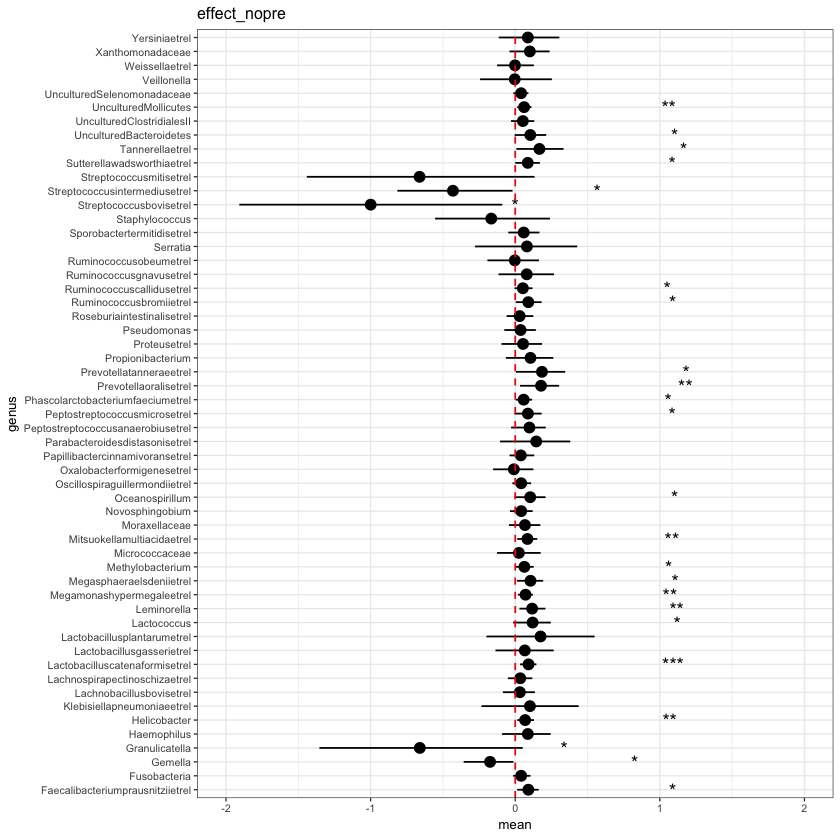

[[1]]
[[1]][[1]]

[[1]][[2]]


[[2]]
[[2]][[1]]

[[2]][[2]]


[[3]]
[[3]][[1]]

[[3]][[2]]


[[4]]
[[4]][[1]]

[[4]][[2]]


[[5]]
[[5]][[1]]

[[5]][[2]]



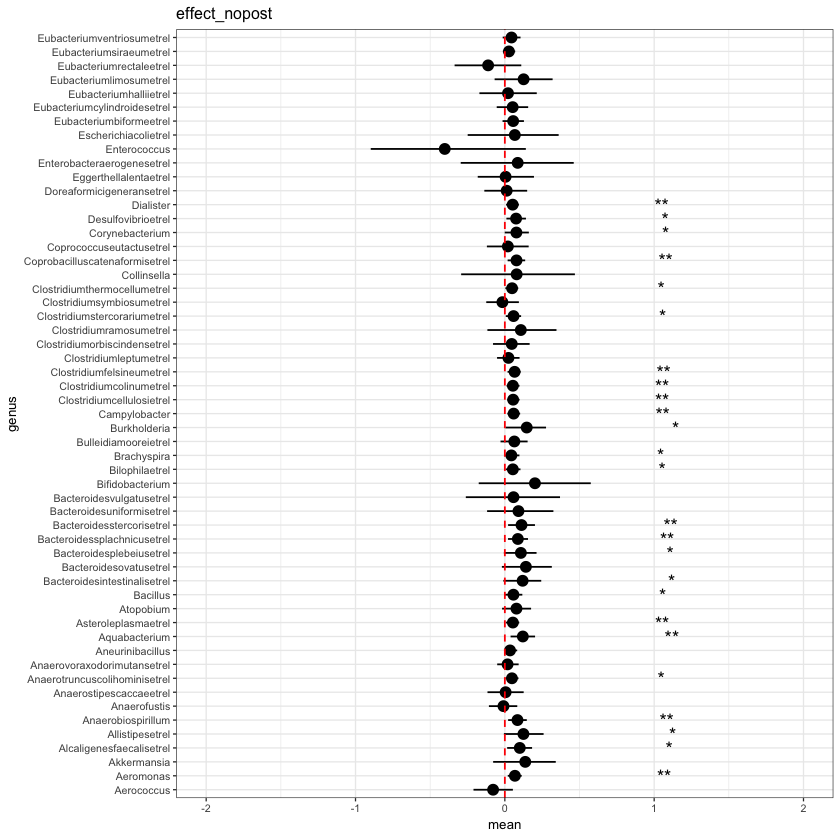

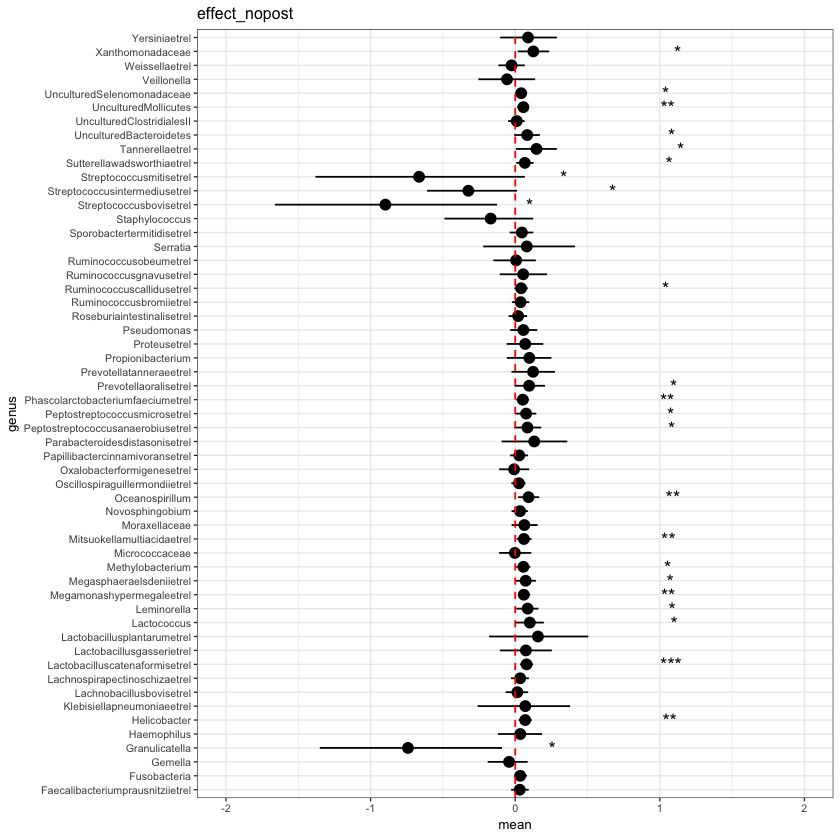

In [43]:
# how are effects distributed
dfs <- list(effect_age = effect_age, effect_bf = effect_bf, effect_yespre = effect_yespre, effect_nopre = effect_nopre, effect_nopost = effect_nopost)
lapply(c("effect_age", "effect_bf", "effect_yespre", "effect_nopre", "effect_nopost"), function(x){
    df <- dfs[[x]] %>% mutate(prob = report_star_nondirectional(prob))
    df1 <- filter(df, genus %in% genus_sel[1:length(genus_sel)/2])
    df2 <- filter(df, genus %in% genus_sel[length(genus_sel)/2+1:length(genus_sel)])
    p1 <- ggplot(df1, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper)) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    
    p2 <- ggplot(df2, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper)) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    list(p1, p2)
})


In [44]:
effect_age <- effect_age %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
effect_bf <- effect_bf %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
effect_yespre <- effect_yespre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
effect_nopre <- effect_nopre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
effect_nopost <- effect_nopost %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
effects <- rbind(effect_age, effect_bf, effect_yespre, effect_nopre, effect_nopost)

effects %>% filter(qvalue < 0.01)

genus                             mean       lower         upper     
1   Gemella                           0.10862773  0.0415225189 0.17552445
2   Streptococcusmitisetrel           0.46825142  0.1933807510 0.77724785
3   Granulicatella                    0.42477182  0.1456727401 0.69444346
4   Streptococcusintermediusetrel     0.19730366  0.0533653024 0.34039125
5   Eubacteriumrectaleetrel           0.11386775  0.0064456657 0.22056155
6   Enterococcus                      0.21060545 -0.0100258970 0.41075537
7   Staphylococcus                    0.16457144  0.0476551699 0.28839959
8   Streptococcusmitisetrel           0.24574511  0.0617024446 0.43330226
9   Veillonella                       0.06973116  0.0124666289 0.12708676
10  Haemophilus                       0.04660540  0.0101188200 0.08784118
11  Bacteroidesintestinalisetrel      0.03715040  0.0038639727 0.07327660
12  Bacteroidesstercorisetrel         0.02712663  0.0005795607 0.05222945
13  Clostridiumcellulosietrel         0.05933648  0.0253427202 0.09017177
14  Clostridiumstercorariumetrel      0.06915952  0.0275819886 0.10973949
15  Faecalibacteriumprausnitziietrel  0.07373375  0.0333993984 0.11942317
16  Bilophilaetrel                    0.06908663  0.0275676083 0.11087149
17  Aneurinibacillus                  0.06016102  0.0245321467 0.09986474
18  Aquabacterium                     0.11300898  0.0504353960 0.18676377
19  Clostridiumfelsineumetrel         0.05544804  0.0199322964 0.09198952
20  Clostridiumthermocellumetrel      0.05646344  0.0189762102 0.09363275
21  Sutterellawadsworthiaetrel        0.07311361  0.0265585887 0.12440329
22  Aeromonas                         0.05929882  0.0171756880 0.09844147
23  Coprobacilluscatenaformisetrel    0.07106865  0.0219552834 0.12145540
24  Mitsuokellamultiacidaetrel        0.05736538  0.0175843727 0.09974736
25  UnculturedMollicutes              0.04679449  0.0143915814 0.08114097
26  Lactobacilluscatenaformisetrel    0.05179750  0.0140679790 0.09030968
27  Megamonashypermegaleetrel         0.04575001  0.0118939812 0.08298997
28  Ruminococcusbromiietrel           0.06331113  0.0142180671 0.11027820
29  Asteroleplasmaetrel               0.05129256  0.0138948269 0.08825717
30  Helicobacter                      0.05043661  0.0117036041 0.08770952
⋮   ⋮                                 ⋮          ⋮             ⋮         
84  Helicobacter                      0.06878878 0.023706659   0.11459530
85  Campylobacter                     0.05898845 0.017040812   0.10256817
86  Megamonashypermegaleetrel         0.05938977 0.018772940   0.10326983
87  UnculturedMollicutes              0.05642949 0.012957213   0.09393726
88  Clostridiumcellulosietrel         0.05554879 0.016635860   0.09880788
89  Anaerobiospirillum                0.08466836 0.022090059   0.14694854
90  Aeromonas                         0.06739698 0.019565357   0.11297156
91  Coprobacilluscatenaformisetrel    0.07821090 0.018626390   0.13616470
92  Bacteroidessplachnicusetrel       0.08710444 0.021394688   0.15507065
93  Oceanospirillum                   0.09194837 0.019904960   0.16570526
94  Phascolarctobacteriumfaeciumetrel 0.05236775 0.007913057   0.09463367
95  Clostridiumcolinumetrel           0.05381703 0.011817024   0.09811545
96  Bacteroidesstercorisetrel         0.11160347 0.021825121   0.20163537
97  Dialister                         0.05243798 0.008448050   0.09423746
98  Mitsuokellamultiacidaetrel        0.05997469 0.010270477   0.11258373
99  Asteroleplasmaetrel               0.05384544 0.006831392   0.09650483
100 Alcaligenesfaecalisetrel          0.10006563 0.015563279   0.18245567
101 Xanthomonadaceae                  0.12514500 0.017698761   0.23462459
102 Methylobacterium                  0.05652188 0.006703230   0.10461311
103 Desulfovibrioetrel                0.07530411 0.010480397   0.14138293
104 Leminorella                       0.08589706 0.006359797   0.16066273
105 Clostridiumstercorariumetrel      0.05825750 0.006219011   0.10893719
106 Clos

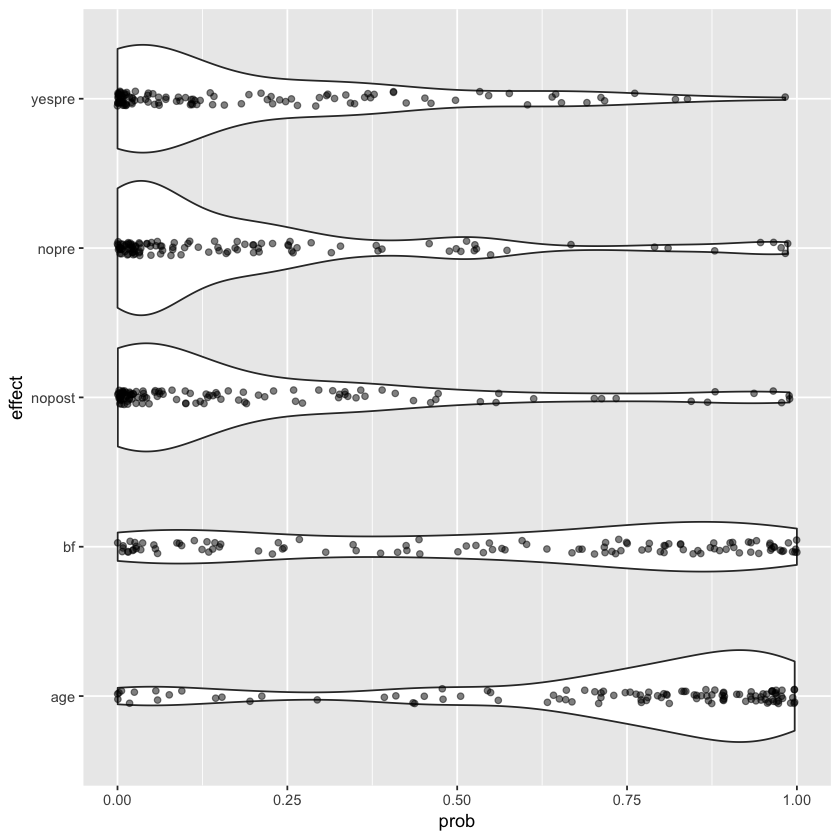

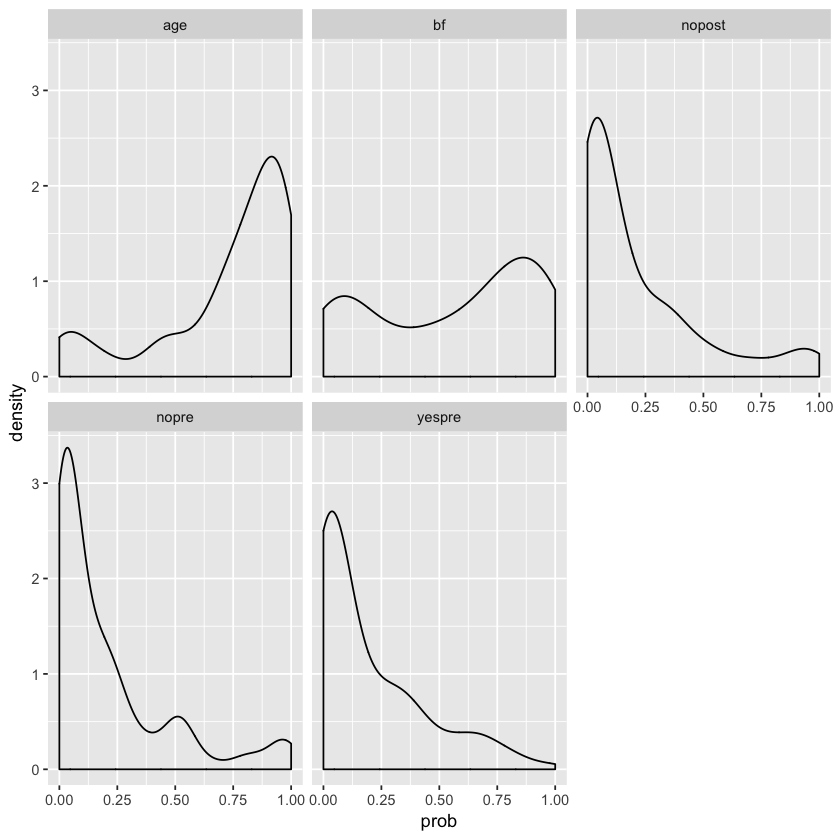

In [46]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
effects %>%
    ggplot(aes(effect, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

effects %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~effect)

In [47]:
# to compare, i do the same with comparisons we did not hypothesize:
p_cc1 = c()
p_cc2 = c()
p_cc3= c()

for (var_name in genus_sel) {
    fit <- brm_sn_mi(var_name)
    df <- calc_treatment_effect(fit, var_name, summarise = F)
    df <- df %>% 
        mutate(            
            nopre_yespre = no_pre - yes_pre,
            nopre_nopost = no_pre - no_post,
            yespre_nopost = yes_pre - no_post) %>%
        select(nopre_yespre, nopre_nopost, yespre_nopost) %>%
        gather(effect, value) %>%
        group_by(effect) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    p_cc1 <- c(p_cc1, df$prob[1])
    p_cc2 <- c(p_cc2, df$prob[2])
    p_cc3 <- c(p_cc3, df$prob[3]) 
    df
}

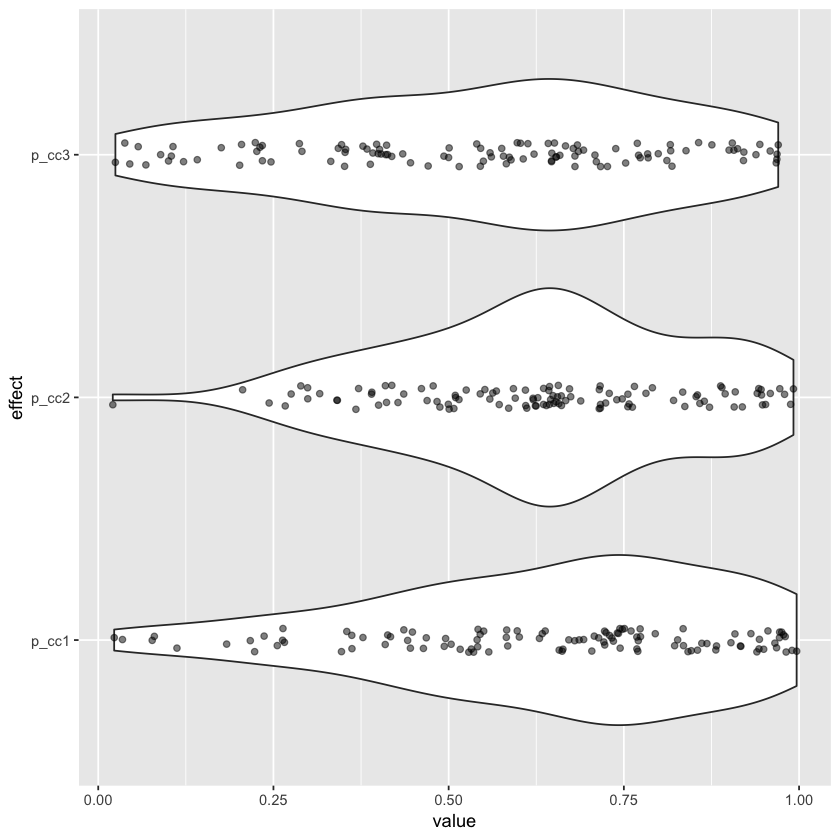

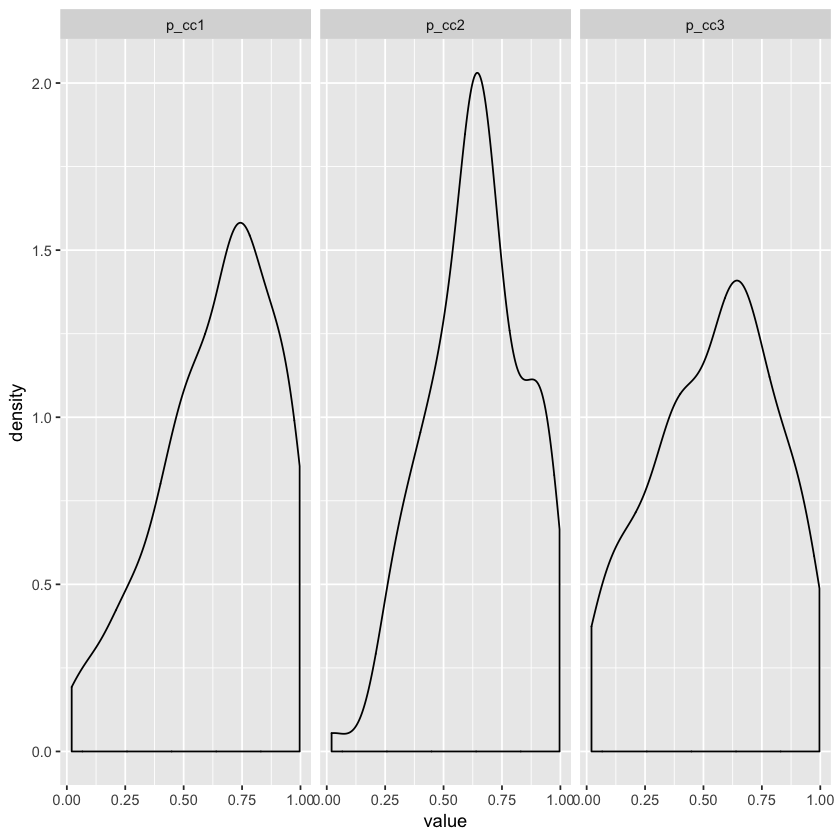

In [48]:
# here the non-hypothesized comparisons. Keep in mind that that time still might cause a signal when
p_values <- tibble(p_cc1, p_cc2, p_cc3)
p_values %>% gather(effect, value) %>%
    ggplot(aes(effect, value)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

p_values %>% gather(effect, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~effect)

In [49]:
# and simulate mean parameters that are similar
group_a <- rnorm(mean = 0, sd = 2, n = 100000)
group_b <- rnorm(mean = 0, sd = 2, n = 100000)
p_vals <- c()
# for 130 comparisons draw 1000 of them and check P(diff < 0):
for (i in 1:130) {
    ran <- tibble(groupa = sample(group_a, 1000), groupb = sample(group_b, 1000))
    p <- mean((ran$groupa - ran$groupb) < 0)
    p_vals <- c(p_vals, p)
}

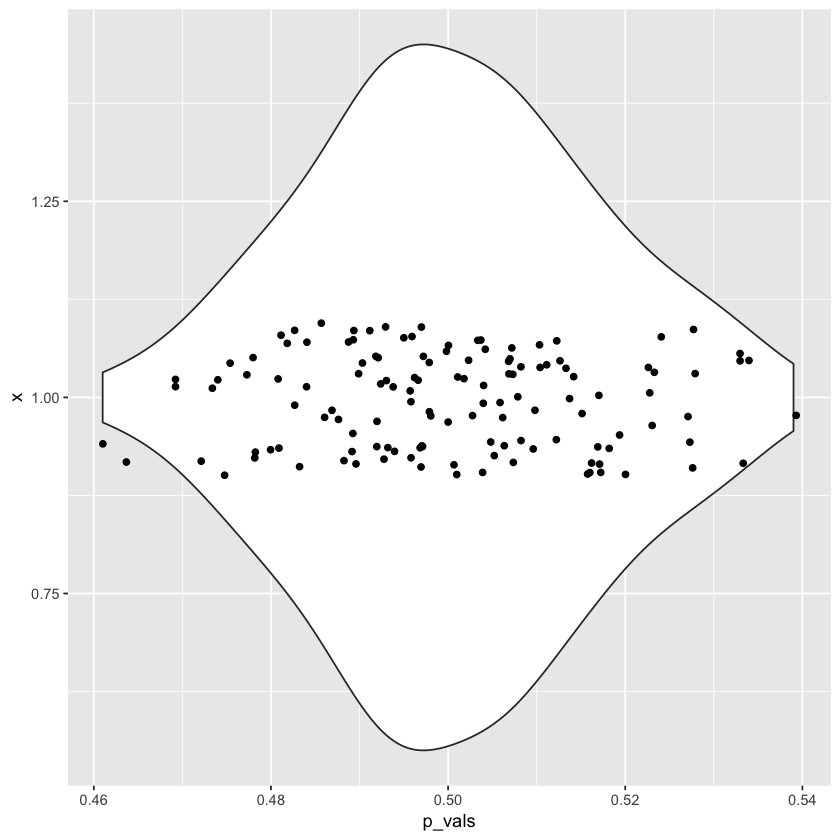

In [50]:
p_vals_df <- tibble(p_vals)
ggplot(p_vals_df, aes(1, p_vals)) +
    geom_violin() +
    geom_jitter(width = 0.1) +
    coord_flip()

## Non-parametric group comparison

In [51]:
ccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "CCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = TRUE, data = df)$p.value)
})

noccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})

noccpost <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpost")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})


In [52]:
ccpre <- ccpre %>% as.tibble() %>% add_column(effect = "ccpre") %>% gather(genus, pvalue, -effect)
noccpre <- noccpre %>% as.tibble() %>% add_column(effect = "noccpre") %>% gather(genus, pvalue, -effect)
noccpost <- noccpost %>% as.tibble() %>% add_column(effect = "noccpost") %>% gather(genus, pvalue, -effect)

In [53]:
# qvalues
ccpre$q <- qvalue(ccpre$pvalue)$qvalues
noccpre$q <- qvalue(noccpre$pvalue, lambda = 0)$qvalues
noccpost$q <- qvalue(noccpost$pvalue)$qvalues
wilcox_result <- rbind(ccpre, noccpre, noccpost)

ERROR: Error in qvalue(ccpre$pvalue): could not find function "qvalue"


In [ ]:
# distribution of p values:
wilcox_result %>%
    ggplot(aes(effect, q)) +
    geom_violin() +
    geom_jitter(width = 0.1, alpha = 0.3) +
    ylim(0, 1) +
    geom_hline(yintercept = 0.1, linetype = "dashed") +
    coord_flip()

In [ ]:
wilcox_result %>% 
    filter(q <= 0.1 & pvalue <= 0.05) 

In [ ]:
kruskal <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x)
    
    colnames(df) <- c("groups", "genus")
    list(x =  kruskal.test(genus~groups, data = df)$p.value)
})


In [ ]:
kruskal <- kruskal %>% as.tibble() %>% gather(genus, pvalue) %>% arrange(pvalue)

In [ ]:
kruskal$q <- qvalue(kruskal$pvalue, lambda = 0)$qvalues

## Frequentist hierarchical modeling

In [ ]:
library(lme4)
library(car)
# i change contrasts to ease comparison, which is a bit different
# in frequentist setting
data.f <- data
contrasts(data.f$cc)[1, 1] <- 1
contrasts(data.f$cc)[2, 1] <- 0
contrasts(data.f$time)[1, 1] <- 1
contrasts(data.f$time)[2, 1] <- 0

In [ ]:
lme_fits <- 
    lapply(genus, function(x) {
        form <- glue("{x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")
        l4fit <- lmer(form, data = data.f)
        lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                    rownames_to_column("effect") %>%
                    add_column(genus = x)
        lme_fit
    })

In [ ]:
lme_all <- plyr::ldply(lme_fits, data.frame)

In [ ]:
lme_cc <- lme_all %>% filter(effect == "cc")
lme_time <- lme_all %>% filter(effect == "time")
lme_age <- lme_all %>% filter(effect == "age_d_s")
lme_bf <- lme_all %>% filter(effect == "bf_count_s")
lme_cctime <- lme_all %>% filter(effect == "cc:time")

In [ ]:
lme_fits <- lapply(list(lme_cc, lme_time, lme_age, lme_bf, lme_cctime), function(df){
    df$q <- qvalue(df$`Pr..F.`)$qvalues
    df
})

In [ ]:
lme_all <- plyr::ldply(lme_fits, data.frame)

In [ ]:
lme_all %>% filter(`Pr..F.`<0.05 & effect == "cc")

In [ ]:
effect_nopost %>% filter(qvalue < 0.01)

In [ ]:
"Vibrio" %in% genus_sel